In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import json
from matplotlib import colormaps
import re
import io
from datetime import datetime


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# This code is used to plot the data from the FE tester for the CV
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

%config InlineBackend.figure_format = 'retina' # For high resolution figures in Jupyter Notebook
#%matplotlib widget

## Operator window

#### Parameters to Specify

- **Input file path**  
- **Output file path**  
- **File name**  
- **Number of points to remove** (in case of breakdown)

⚠️ **Important:** Pay attention to the **output path**. The program will automatically create **4 subfolders** in the output path to store the plots and the CSV file.

In [2]:
# Set the path to the data file
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

file_path = r'E:\Nextcloud\06 - FeCAP-FTJ\02 - Data\02 - FE tester\NASA_FeCAP_06\Endurance measurement - DHM'
output_path = r'E:\Nextcloud\06 - FeCAP-FTJ\01 - Results\02 - FE tester\NASA_FeCAP_06\Endurance measurement - DHM'
file_name = 'NASA_FeCAP_06_ID_23-00_FM.dat'
full_path = os.path.join(file_path, file_name)

# If we have a breakdown during the measurement, we can remove the last n points
point_removal = 3

# Extract the last folder name from the file path
last_folder = os.path.basename(os.path.dirname(file_path))
print(last_folder)

# Séparer nom et extension
base_name = os.path.splitext(file_name)[0]
print(base_name)  # ➜ NASA_SL_ALE_10_ID_095

NASA_FeCAP_06
NASA_FeCAP_06_ID_23-00_FM


## Complete fatigue analysis

File extraction

In [3]:
# --- Fatigue .dat → structured DataFrame (user‑friendly commented version) ---
# This script locates and parses the "Result Table" block from a FE tester .dat file.
# Steps:
# 1) Scan the file to find the first "Result Table" (start of the block) and the first
#    "Data Table" (end of the block).
# 2) Slice the file lines to keep only the metadata + data for that fatigue block.
# 3) Extract key metadata values (sample name, area, fatigue/hysteresis parameters).


with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:

    for i, line in enumerate(f):
        # Find the first occurrence of a "Result Table" header → just after it starts the block.
        if "Result Table" in line:
            print(f"Found the start of the table block at line {i+1}: {line.strip()}")
            start_index = i + 1  # exclude the marker line itself

        # Find the first occurrence of a "Data Table" header → this marks the end of the block.
        if "Data Table" in line:
            print(f"Found the end of the table block at line {i}: {line.strip()}")
            end_index = i  # exclude the end marker line
            break  # stop scanning once the first block is delimited

# Read all lines once we know the indices so we can slice them.
with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()


# Keep only the lines within the block [start_index:end_index].
data_lines_complete_fatigue = lines[start_index:end_index]
# Free memory for large files.
del start_index, end_index, lines

# --- Initialize metadata placeholders ---
Measurement_date = None

SampleName = None
Area_mm2 = None

Fatigue_Amplitude_V = None
Fatigue_Offset_V = None
Fatigue_Frequency_Hz = None
Total_Cycles = None
PtsPerDecade = None

Hysteresis_Frequence_Hz = None
Hysteresis_Amplitude_V = None

# --- Parse metadata lines (keep the first occurrence of each field) ---
for line in data_lines_complete_fatigue:
    if "Fatigue Amplitude [V]" in line and Fatigue_Amplitude_V is None:
        Fatigue_Amplitude_V = line.strip()
    if "Fatigue Offset [V]" in line and Fatigue_Offset_V is None:
        Fatigue_Offset_V = line.strip()
    if "Fatigue Frequency [Hz]" in line and Fatigue_Frequency_Hz is None:
        Fatigue_Frequency_Hz = line.strip()
    if "Total Cycles" in line and Total_Cycles is None:
        Total_Cycles = line.strip()
    if "PtsPerDecade" in line and PtsPerDecade is None:
        PtsPerDecade = line.strip()
    if "SampleName" in line and SampleName is None:
        SampleName = line.strip()
    if "Area [mm2]" in line and Area_mm2 is None:
        Area_mm2 = line.strip()
    if "Hysteresis Amplitude [V]" in line and Hysteresis_Amplitude_V is None:
        Hysteresis_Amplitude_V = line.strip()
    if "Hysteresis Frequency [Hz]" in line and Hysteresis_Frequence_Hz is None:
        Hysteresis_Frequence_Hz = line.strip()
    if "Timestamp:" in line and Measurement_date is None:
        Measurement_date = line.strip().split("Timestamp:")[1].strip()

# Convert area from mm² to µm² (useful for normalizing currents/charges later on)
Device_area_um2 = float(Area_mm2.split(":")[1].strip()) * 1e6  # mm² → µm²

if Measurement_date is not None:
    Measurement_date = datetime.strptime(Measurement_date, "%m/%d/%Y %H:%M:%S")
    Measurement_date = Measurement_date.strftime("%Y-%m-%d")
    print(f"Measurement date: {Measurement_date}")
else:
    print("Measurement date not found.")
    Measurement_date = "Unknown"

# Optional cosmetic cleanup: keep the substring starting from the keyword "Hysteresis"
keyword = "Hysteresis"
if keyword in Hysteresis_Amplitude_V:
    Hysteresis_Amplitude_V = keyword + Hysteresis_Amplitude_V.split(keyword, 1)[1]
if keyword in Hysteresis_Frequence_Hz:
    Hysteresis_Frequence_Hz = keyword + Hysteresis_Frequence_Hz.split(keyword, 1)[1]

# --- Locate the tabular data region ---
# We consider the first line that contains many tabs as the header (column names),
# then we stop when reaching the "Data Measurement Parameters" section.
header_index = None
ender_index = None
for idx, line in enumerate(data_lines_complete_fatigue):
    if line.count('\t') > 5 and header_index is None:
        header_index = idx  # likely the header row of the data table
    if "Data Measurement Parameters" in line and ender_index is None:
        ender_index = idx   # end of the data table block
        break

# Extract only the data table (including the header row)
data_frame_fatigue = data_lines_complete_fatigue[header_index:ender_index]
print(f"Data header found at relative line {header_index}, end marker at {ender_index}")

# --- Load the table into a DataFrame ---
# The FE tester exports tab‑delimited text. We pass it directly to pandas.
data_frame_fatigue = pd.read_csv(io.StringIO(''.join(data_frame_fatigue)), sep='\t', engine='python')

# --- Select columns of interest (adjust names if your tester uses a different locale) ---
Cycles_total = data_frame_fatigue['Cycles [n]']
fatigue_Pr_pos = data_frame_fatigue['1-DHM Pr+ [uC/cm2]']
fatigue_Pr_neg = data_frame_fatigue['1-DHM Pr- [uC/cm2]']

fatigue_Vc_pos = data_frame_fatigue['1-DHM Vc+ [V]']
fatigue_Vc_neg = data_frame_fatigue['1-DHM Vc- [V]']
fatigue_Wloss = data_frame_fatigue['1-DHM Wloss [uJ/cm2]']
fatigue_Ipk_pos = data_frame_fatigue['1-DHM Ipk+ [A]']
fatigue_Ipk_neg = data_frame_fatigue['1-DHM Ipk- [A]']

# --- Trim trailing non‑data rows ---
# Many FE tester exports append ~4 lines of footers after the numeric table.
# We drop the last 4 rows defensively. Adjust if your files differ.
if point_removal > 0:
    Cycles = Cycles_total.iloc[:-point_removal]
    fatigue_Pr_pos = fatigue_Pr_pos.iloc[:-point_removal]
    fatigue_Pr_neg = fatigue_Pr_neg.iloc[:-point_removal]
    fatigue_Vc_pos = fatigue_Vc_pos.iloc[:-point_removal]
    fatigue_Vc_neg = fatigue_Vc_neg.iloc[:-point_removal]
    fatigue_Wloss = fatigue_Wloss.iloc[:-point_removal]
    fatigue_Ipk_pos = fatigue_Ipk_pos.iloc[:-point_removal]
    fatigue_Ipk_neg = fatigue_Ipk_neg.iloc[:-point_removal]
else:
    Cycles = Cycles_total


Found the start of the table block at line 10: Result Table 1
Found the end of the table block at line 93: Data Table [1,1]
Measurement date: 2025-09-01
Data header found at relative line 21, end marker at 47


Plot Endurance measurement Pr

In [4]:
label_size = 13

# Create the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Plot

axs[0,0].plot(Cycles, fatigue_Pr_pos, color=(0.25, 0.55, 0.85),marker='o', label ='Pr+')
axs[0,0].plot(Cycles, abs(fatigue_Pr_neg), color=(0.25, 0.85, 0.55),marker='o', label ='Pr-')
axs[0,0].set_xlabel("Cycles [n]", fontsize = label_size)
axs[0,0].set_ylabel("Pr (μC/cm²)", fontsize = label_size)
axs[0,0].set_xscale('log')
axs[0,0].set_title(f"Pr")
axs[0,0].legend()
axs[0,0].tick_params(axis='both', labelsize= label_size)

ax1 = axs[0, 1]
ax2 = ax1.twinx()  # Second y-axis on the same subplot
ax1.plot(Cycles, fatigue_Ipk_pos/Device_area_um2, label=f'Jpk +', color=(0.85, 0.55, 0.25), marker='o')
ax2.plot(Cycles, fatigue_Ipk_neg/Device_area_um2, label=f'Jpk -', color=(0.55, 0.25, 0.85), marker='o')
axs[0,1].set_title("Peak current density Jpk")
axs[0,1].set_xscale('log')
axs[0,1].set_xlabel("Cycles [n]", fontsize = label_size)
ax1.set_ylabel("Jpk + [A/μm²]", color = (0.85, 0.55, 0.25), fontsize = label_size)
ax2.set_ylabel("Jpk - [A/μm²]", color = (0.55, 0.25, 0.85), fontsize = label_size)
ax1.tick_params(axis='both', labelsize=label_size)
ax2.tick_params(axis='both', labelsize=label_size)

axs[1,0].plot(Cycles, fatigue_Vc_pos, color=(0.25, 0.55, 0.85),marker='o', label ='Vc+')
axs[1,0].plot(Cycles, abs(fatigue_Vc_neg), color=(0.25, 0.85, 0.55),marker='o', label ='Vc-')
axs[1,0].set_xlabel("Cycles [n]", fontsize = label_size)
axs[1,0].set_ylabel("Vc (V)", fontsize = label_size)
axs[1,0].set_xscale('log')
axs[1,0].set_title("Vc")
axs[1,0].legend()
axs[1,0].tick_params(axis='both', labelsize=label_size)

axs[1,1].plot(Cycles, fatigue_Wloss, label=f'Cycle ', color=(0.85, 0.55, 0.25), marker='o')
axs[1,1].set_xlabel("Cycles [n]", fontsize = label_size)
axs[1,1].set_ylabel("Wloss (μJ/cm²)", fontsize = label_size)
axs[1,1].set_xscale('log')
axs[1,1].set_title("W loss")
axs[1,1].tick_params(axis='both', labelsize=label_size)


info_text = f"{SampleName}\n{Area_mm2}\n\n{Fatigue_Amplitude_V}\n{Fatigue_Offset_V}\n{Fatigue_Frequency_Hz}\n{Total_Cycles}\n{PtsPerDecade}\nNumber of breakdown:{point_removal}\n\n{Hysteresis_Amplitude_V}\n{Hysteresis_Frequence_Hz}"

# Add a text box with device info to the right of the plots
fig.text(
    0.85,   # X position (shifted further to the right)
    0.5,    # Y position (0=bottom, 1=top)
    info_text,
    fontsize=13,
    va='center',
    bbox=dict(boxstyle="round", facecolor="whitesmoke", edgecolor="gray")
)

# Adjust layout to leave more room for the text box
plt.subplots_adjust(right=0.8)
output_path_02 = os.path.join(output_path, base_name)
os.makedirs(output_path_02, exist_ok=True)  # Ensure output directory exists
output_main_plot = os.path.join(output_path_02, "Main plot")
os.makedirs(output_main_plot, exist_ok=True)  # Ensure output directory exists
# Save figure (bbox_inches='tight' ensures everything fits inside)
plt.savefig(
    os.path.join(output_main_plot, f"{Measurement_date}_{base_name}_Fatigue_Main_Plot.png"),
    dpi=300,
    bbox_inches='tight'
)

plt.show()
plt.close(fig)  # Close figure to free memory


## DHM analysis

Data analysis

In [5]:
# Read all lines once we know the indices so we can slice them.
with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

index_table = []

for i, str in enumerate(lines):
    if f"Data Table [1," in str:
        index_table.append(i)

#DHM is metadate + data of every DHM loop
DHM = []
for i, index in enumerate(index_table):  

    if i < len(Cycles_total) - 1:
        DHM.append(lines[index:index_table[i+1]])
    if i == len(Cycles_total) - 1:
        DHM.append(lines[index:])



#DHM_dataframe is only the data without metadata
DHM_dataframe=[]
header_index = None

for i, loop in enumerate(DHM):
    header_index = None
    for idx, line in enumerate(loop):
        if line.count('\t') > 5 and header_index is None:
            header_index = idx
            break
    if header_index is not None:
        data_block = loop[header_index:]
        df = pd.read_csv(io.StringIO(''.join(data_block)), sep='\t', engine='python')
        DHM_dataframe.append(df)

if point_removal > 0:
        DHM_dataframe = DHM_dataframe[:-point_removal]

print(len(DHM_dataframe), "P-V loops loaded.")

# Add a column with the cycle number to each DataFrame
for i, (df, cycle) in enumerate(zip(DHM_dataframe, Cycles)):
    df.insert(0, "Cycle", cycle)  # Add a column at the first position with the cycle number

# Concatenate all DataFrames into a single DataFrame and save to CSV
DHM_dataframe_csv = pd.concat(DHM_dataframe, axis=1)
output_csv_data_path = os.path.join(output_path_02, "CSV data")
os.makedirs(output_csv_data_path, exist_ok=True)  # Ensure output directory exists

DHM_dataframe_csv.to_csv(os.path.join(output_csv_data_path, f"{Measurement_date}_{base_name}_FatigueDHM.csv"), index=False)


21 P-V loops loaded.


Plot

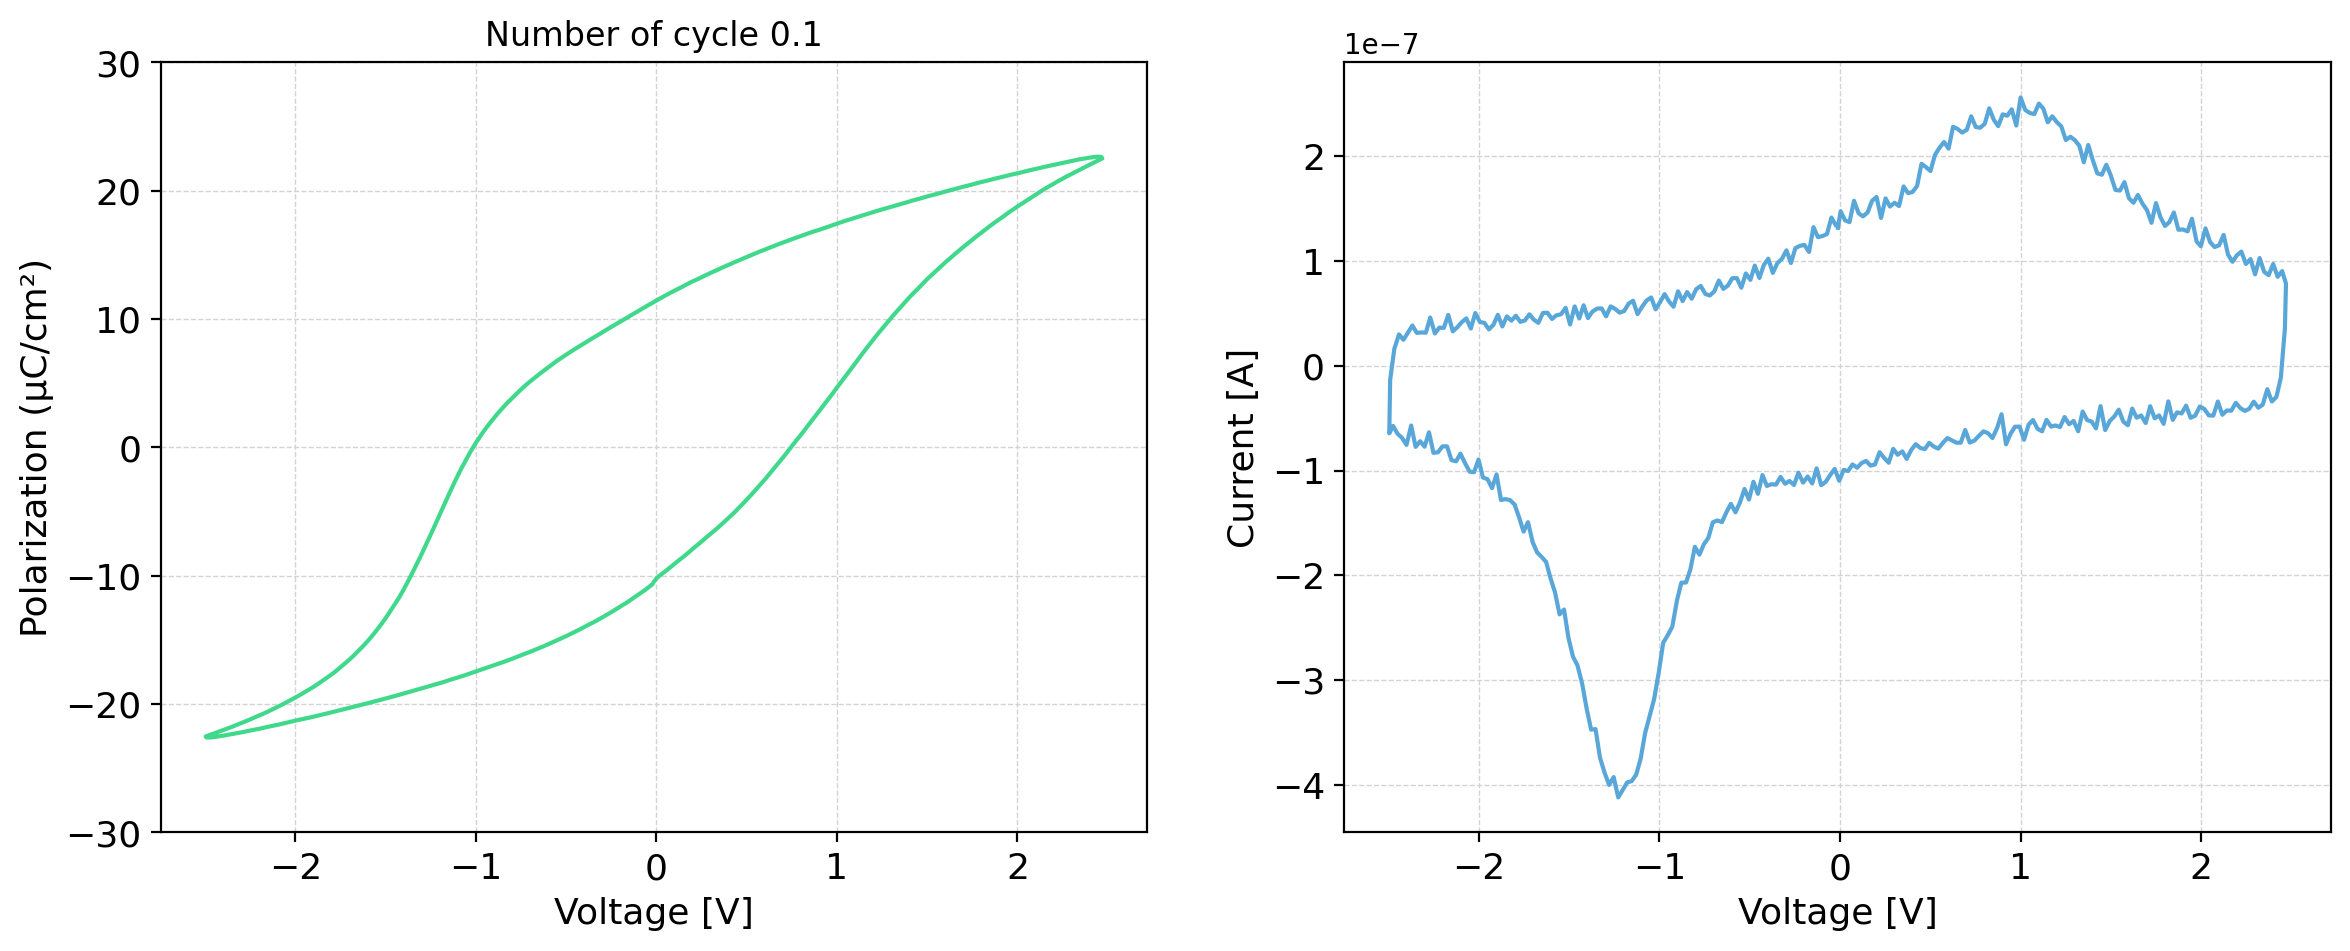

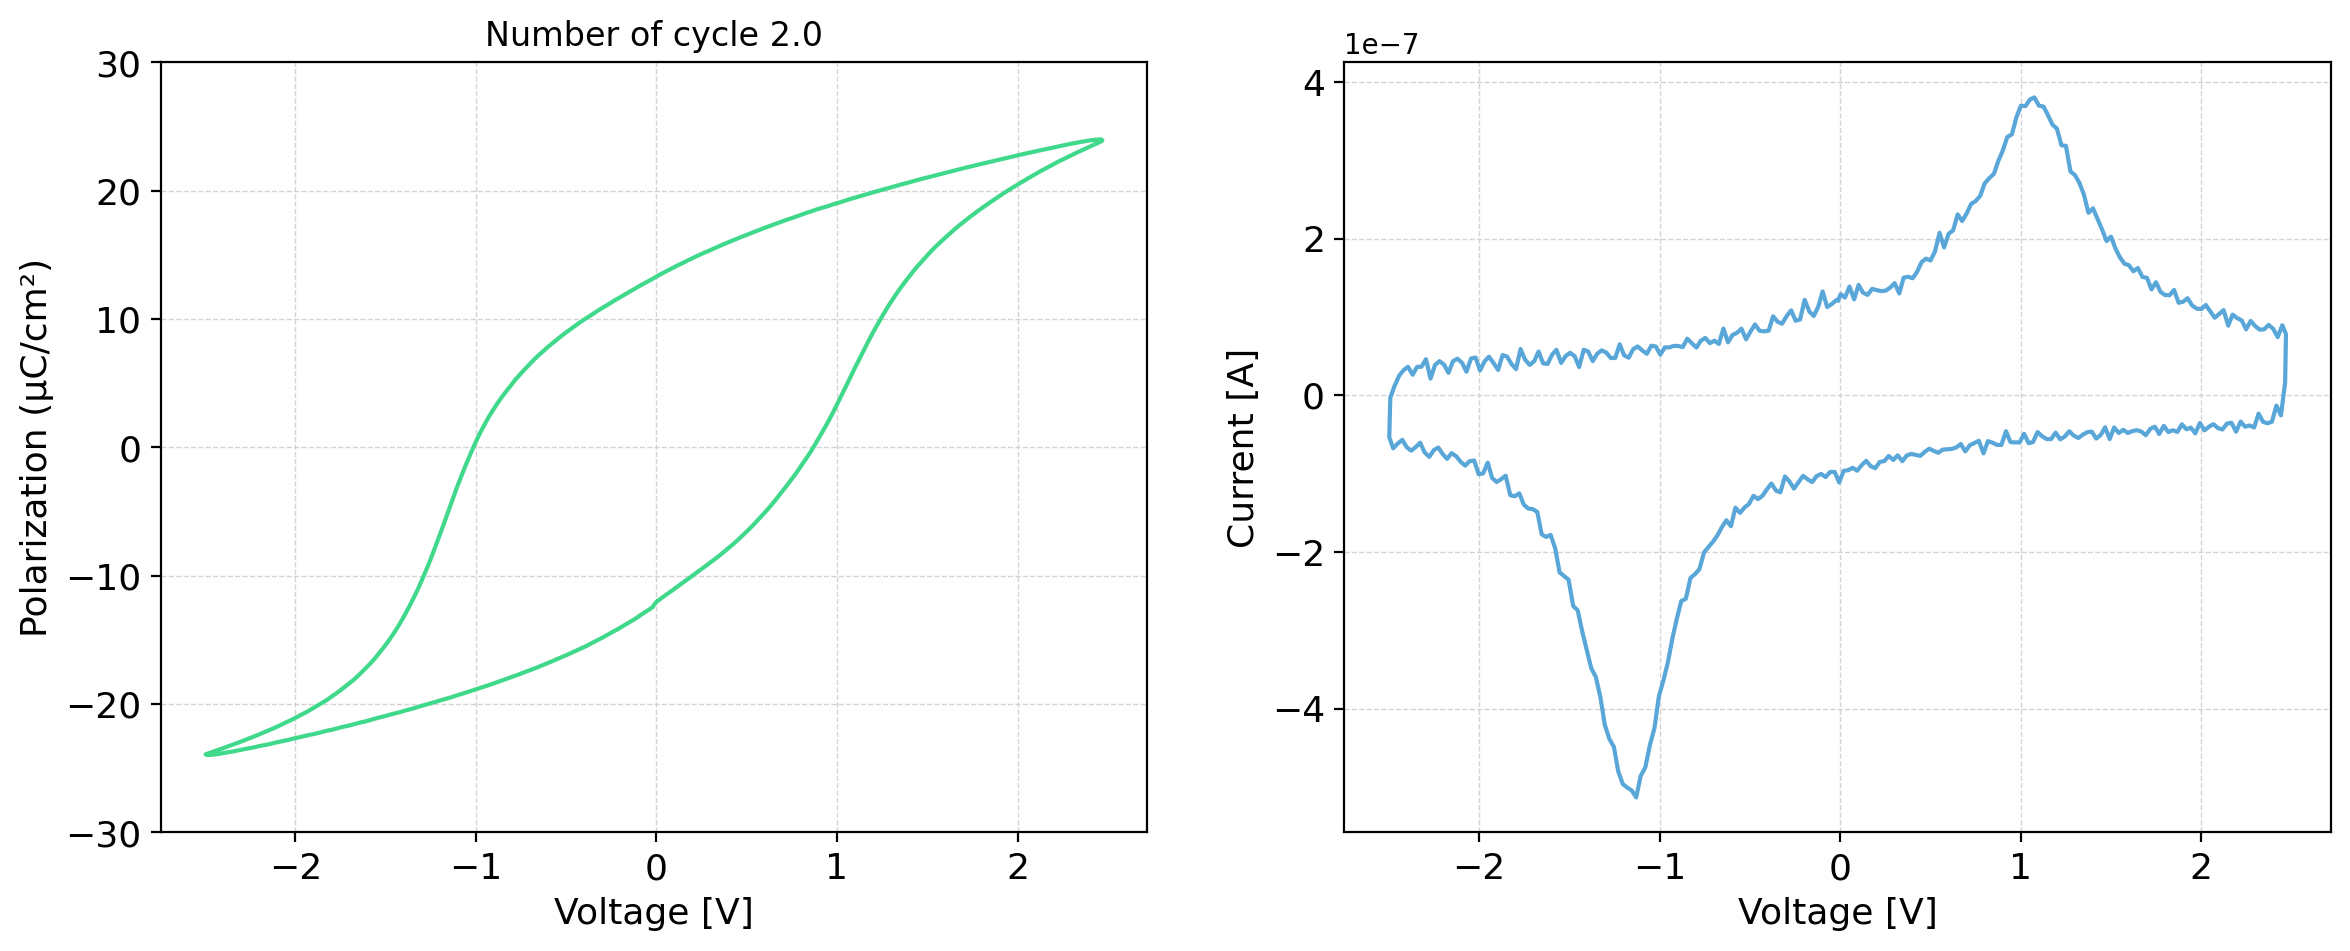

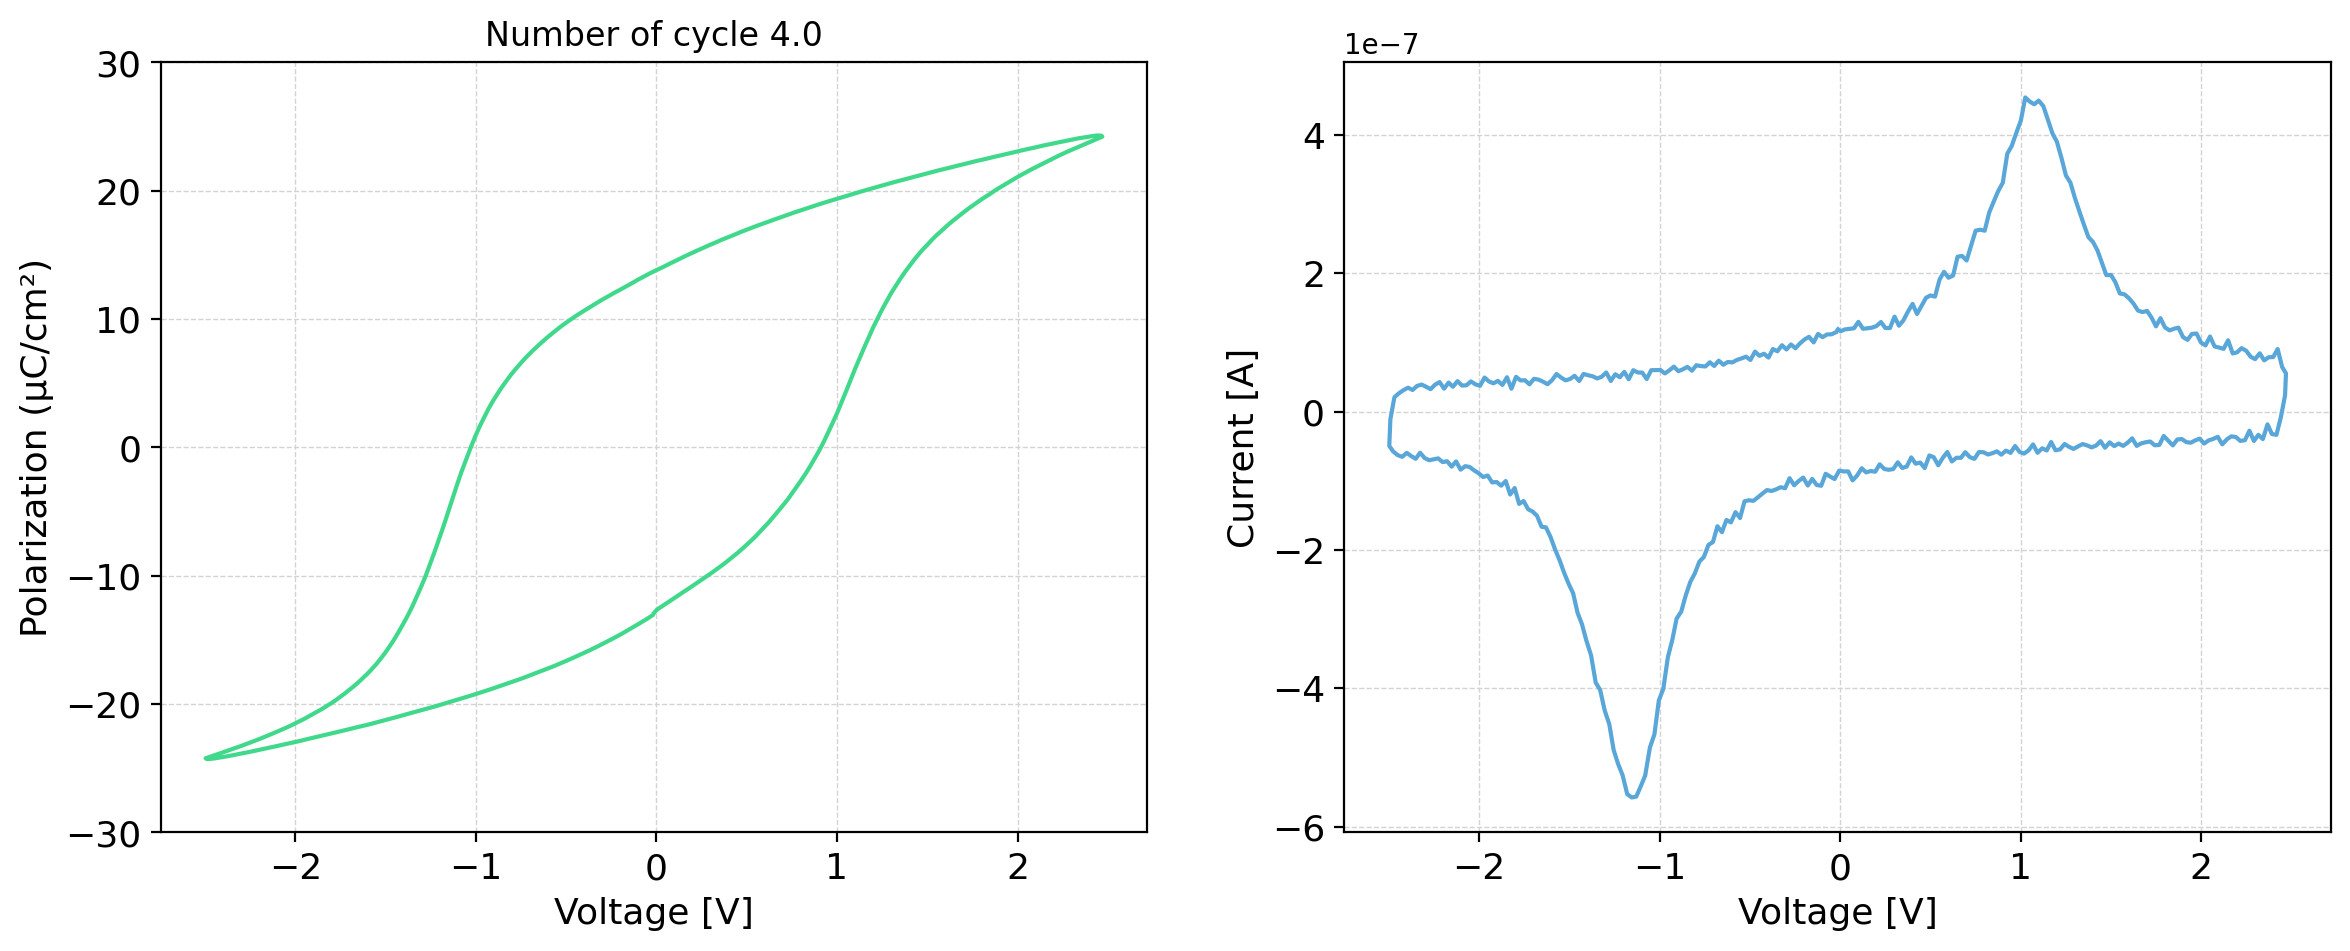

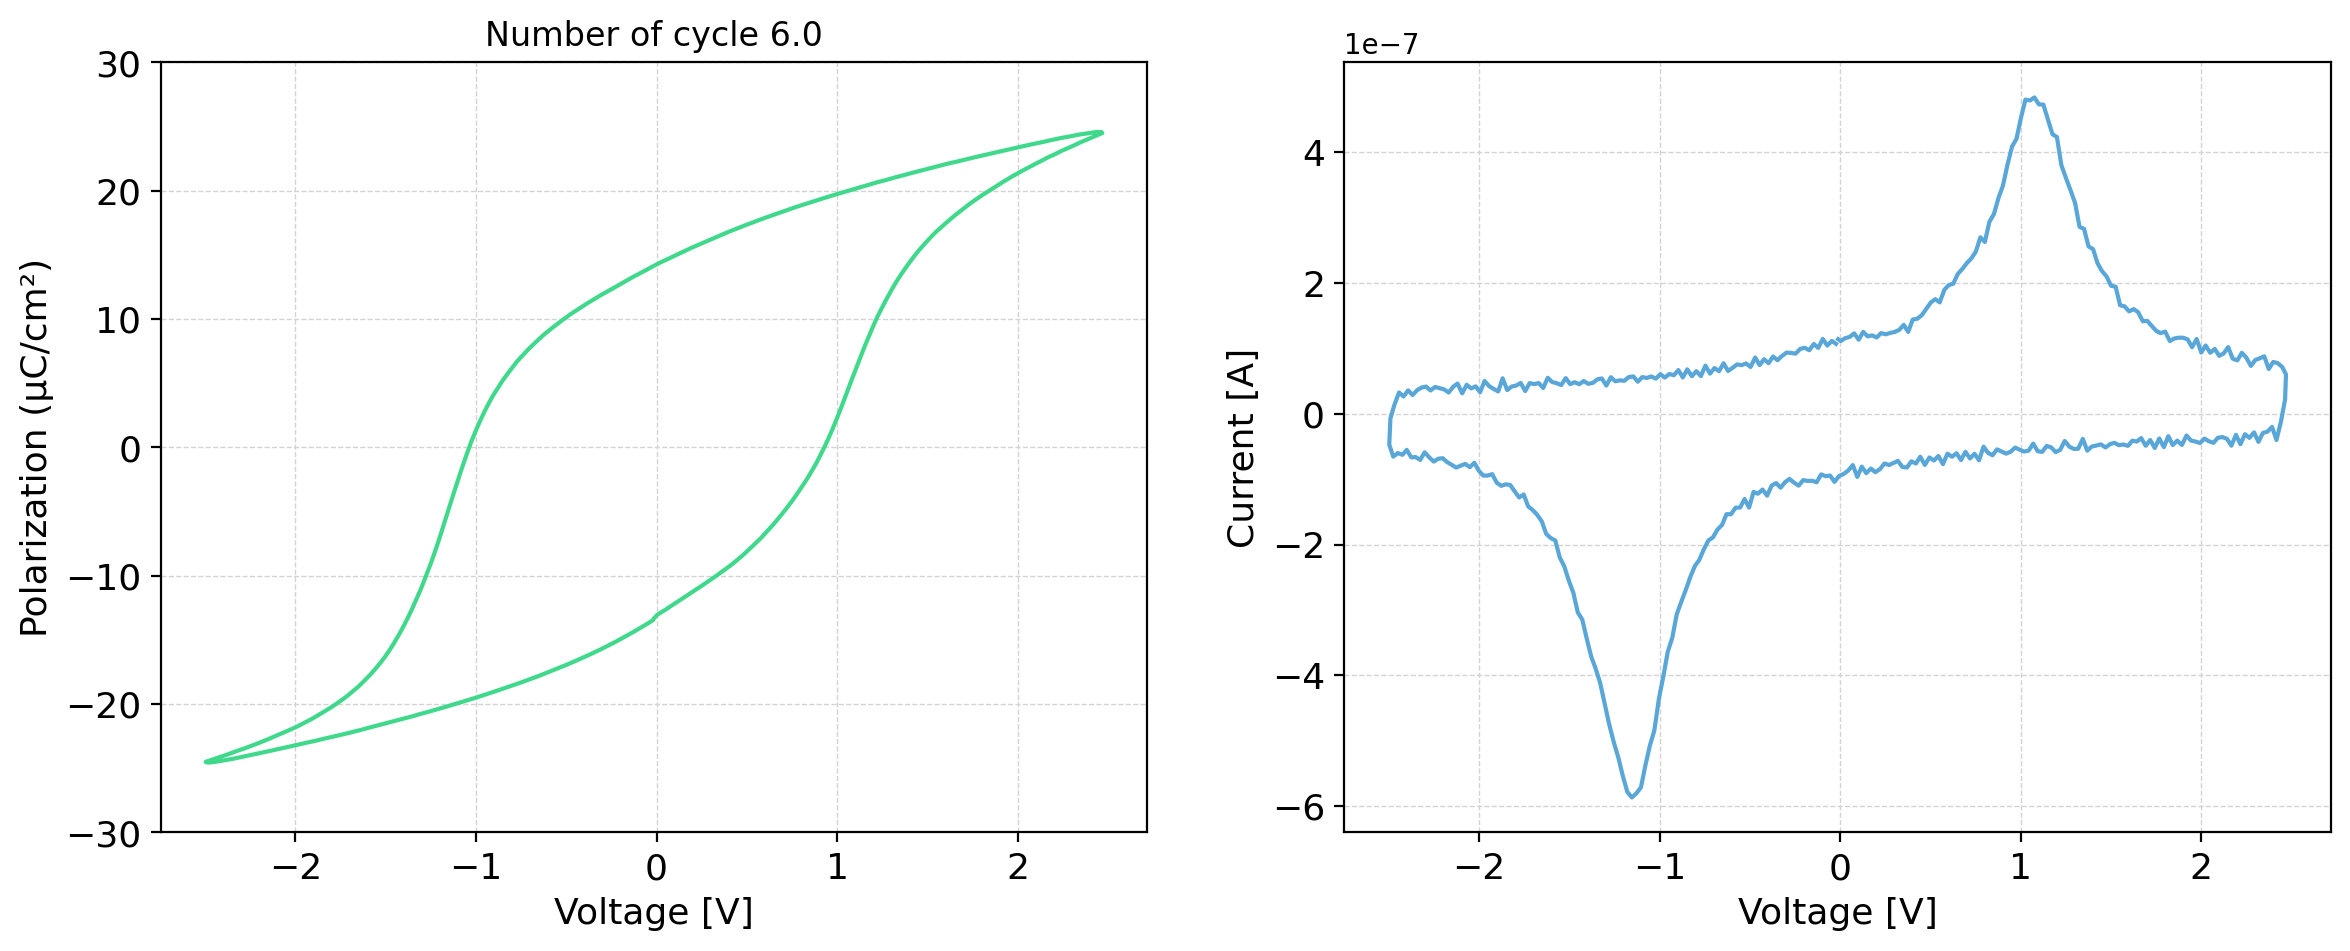

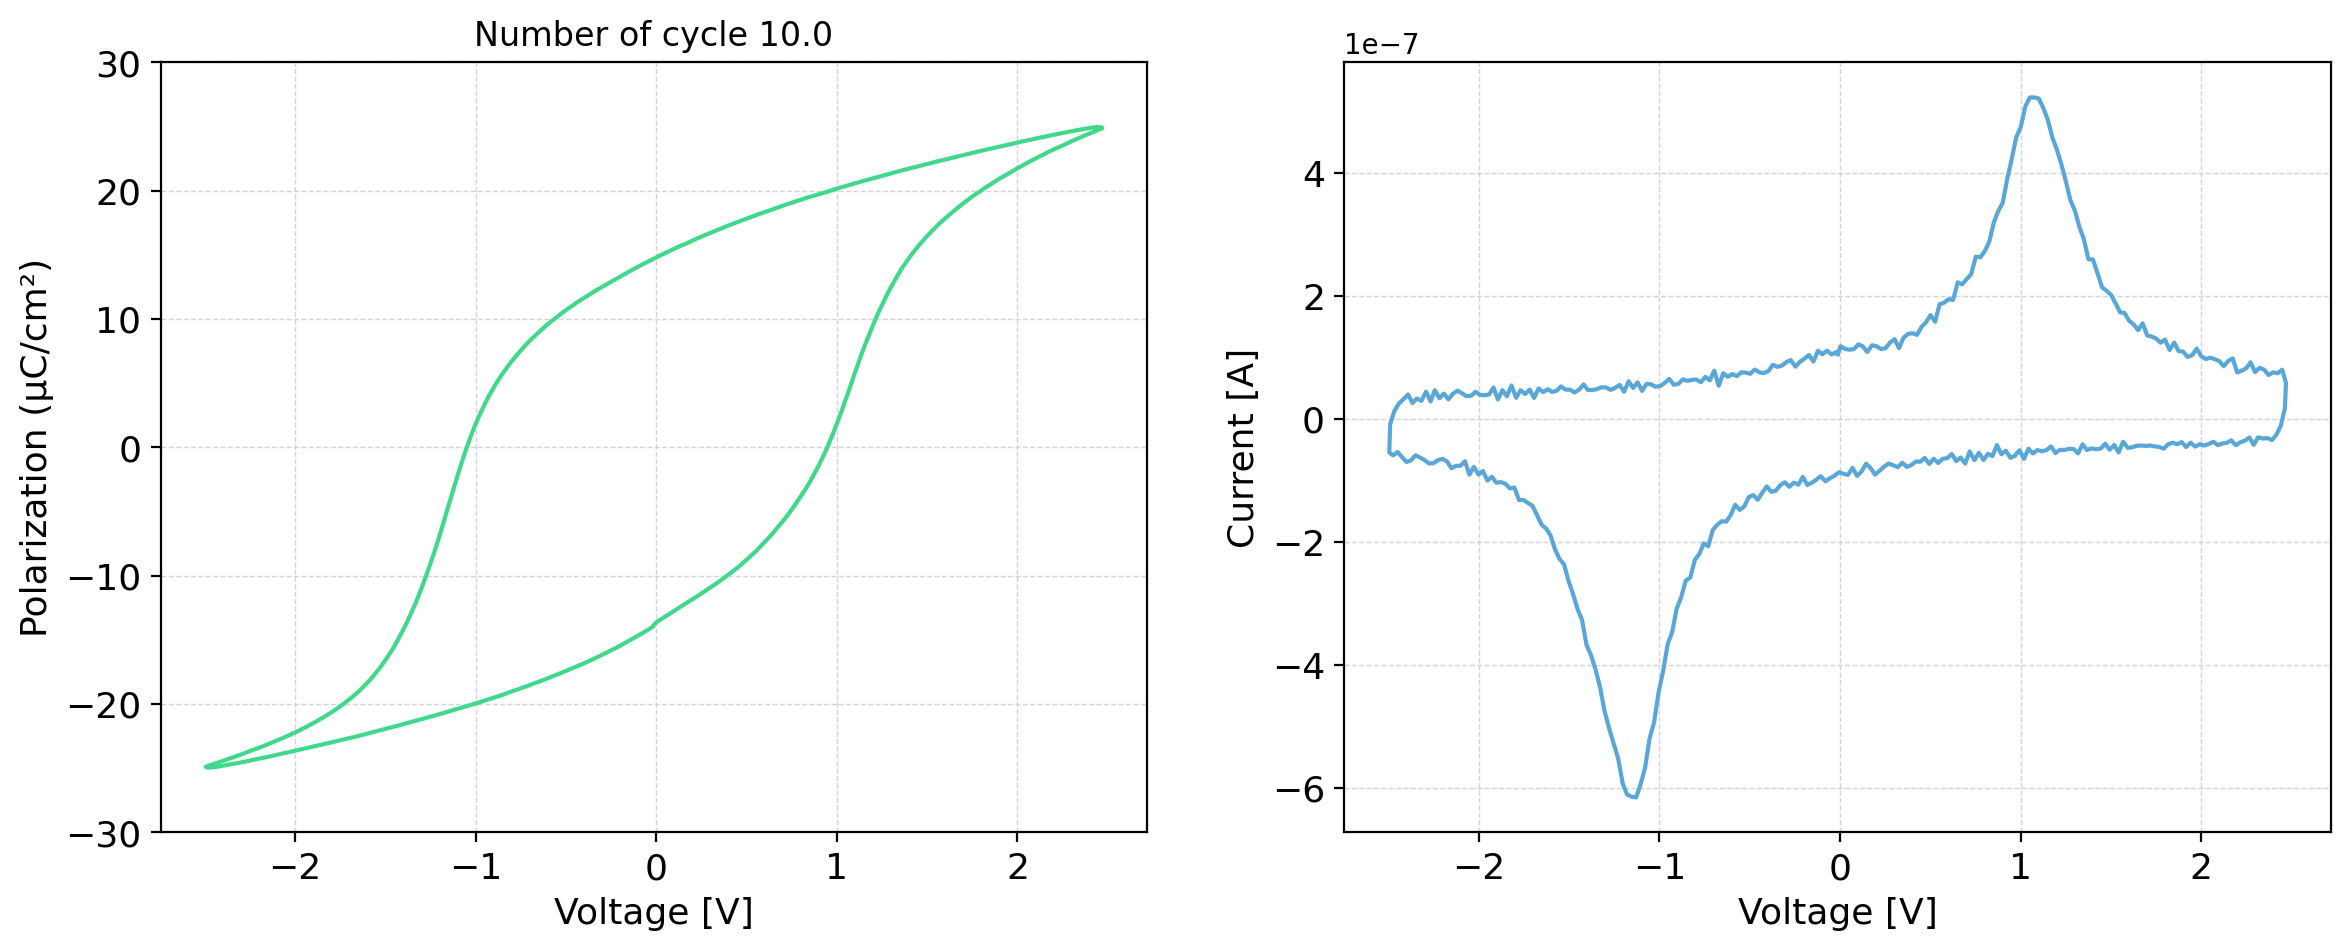

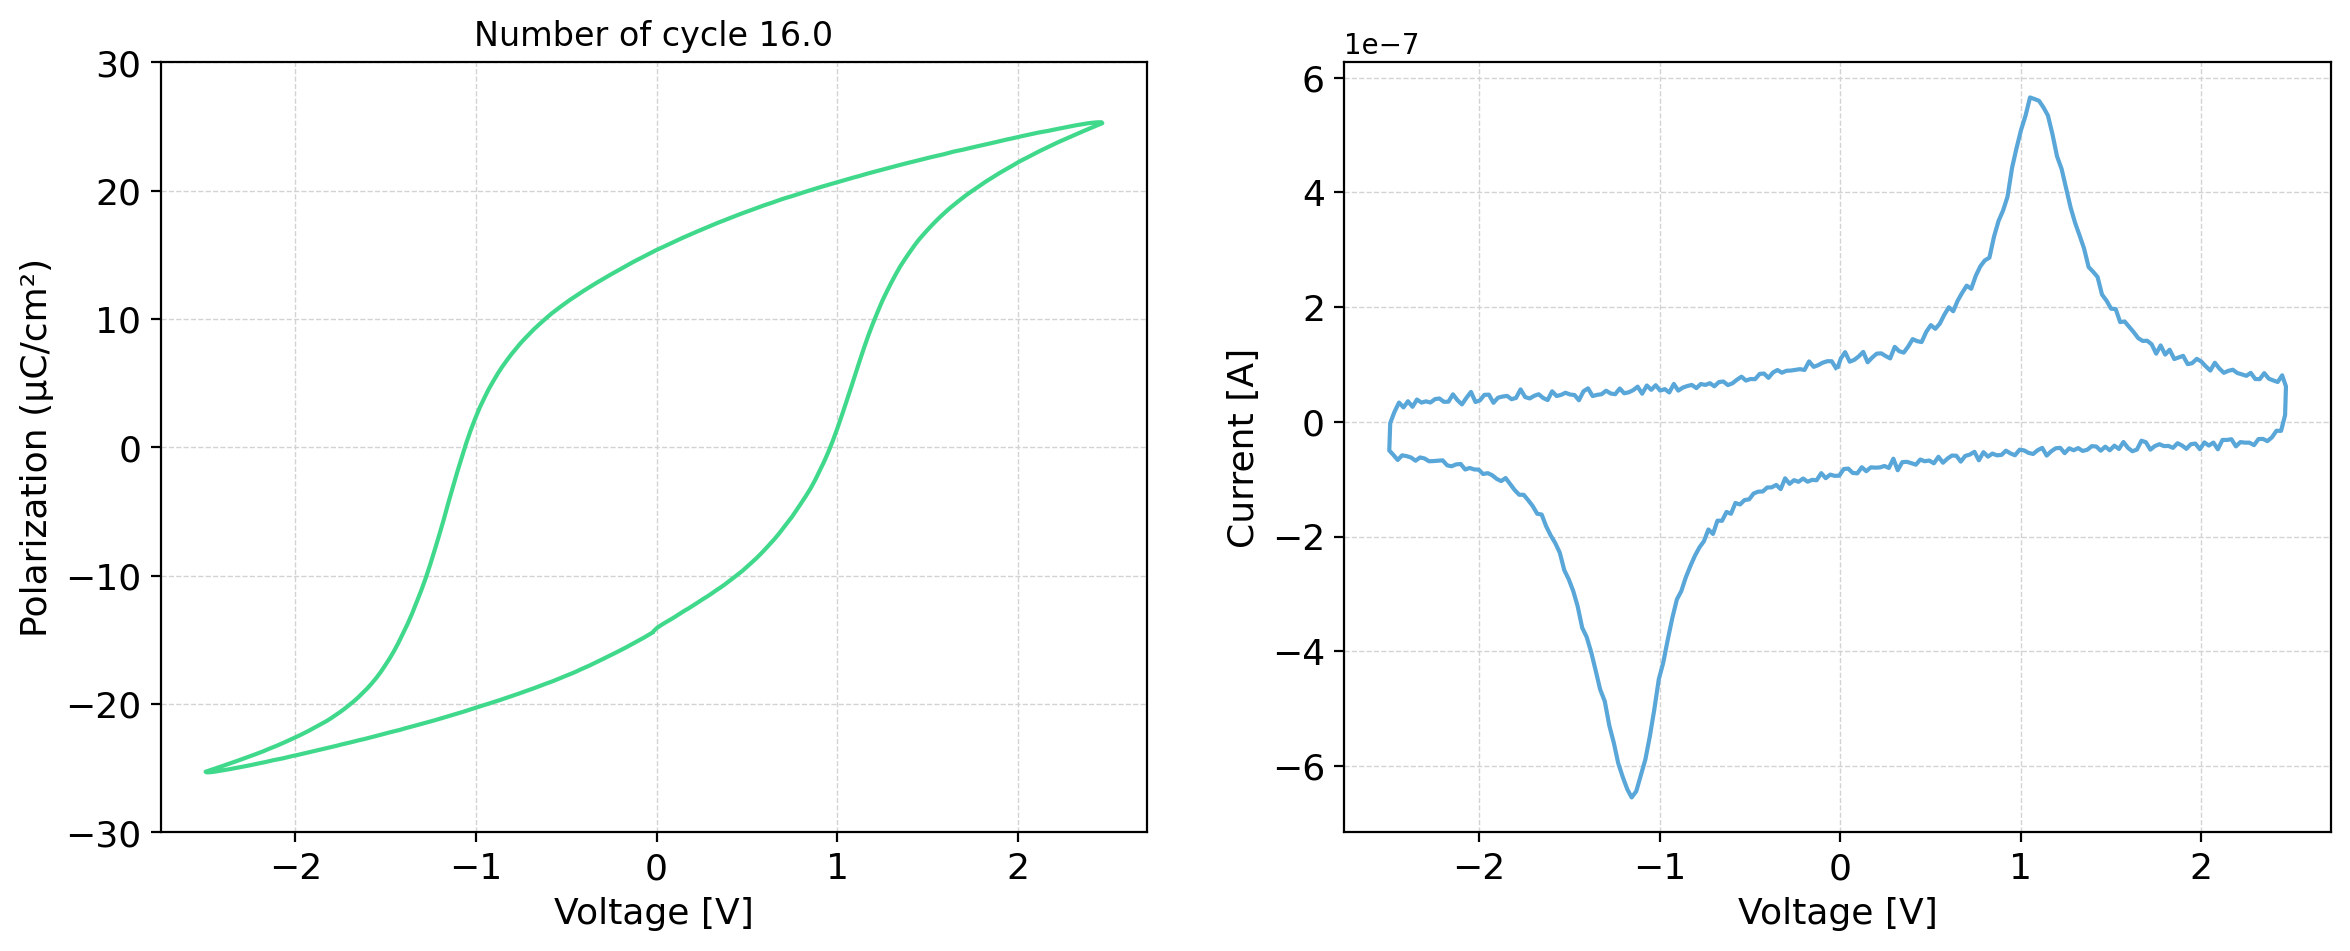

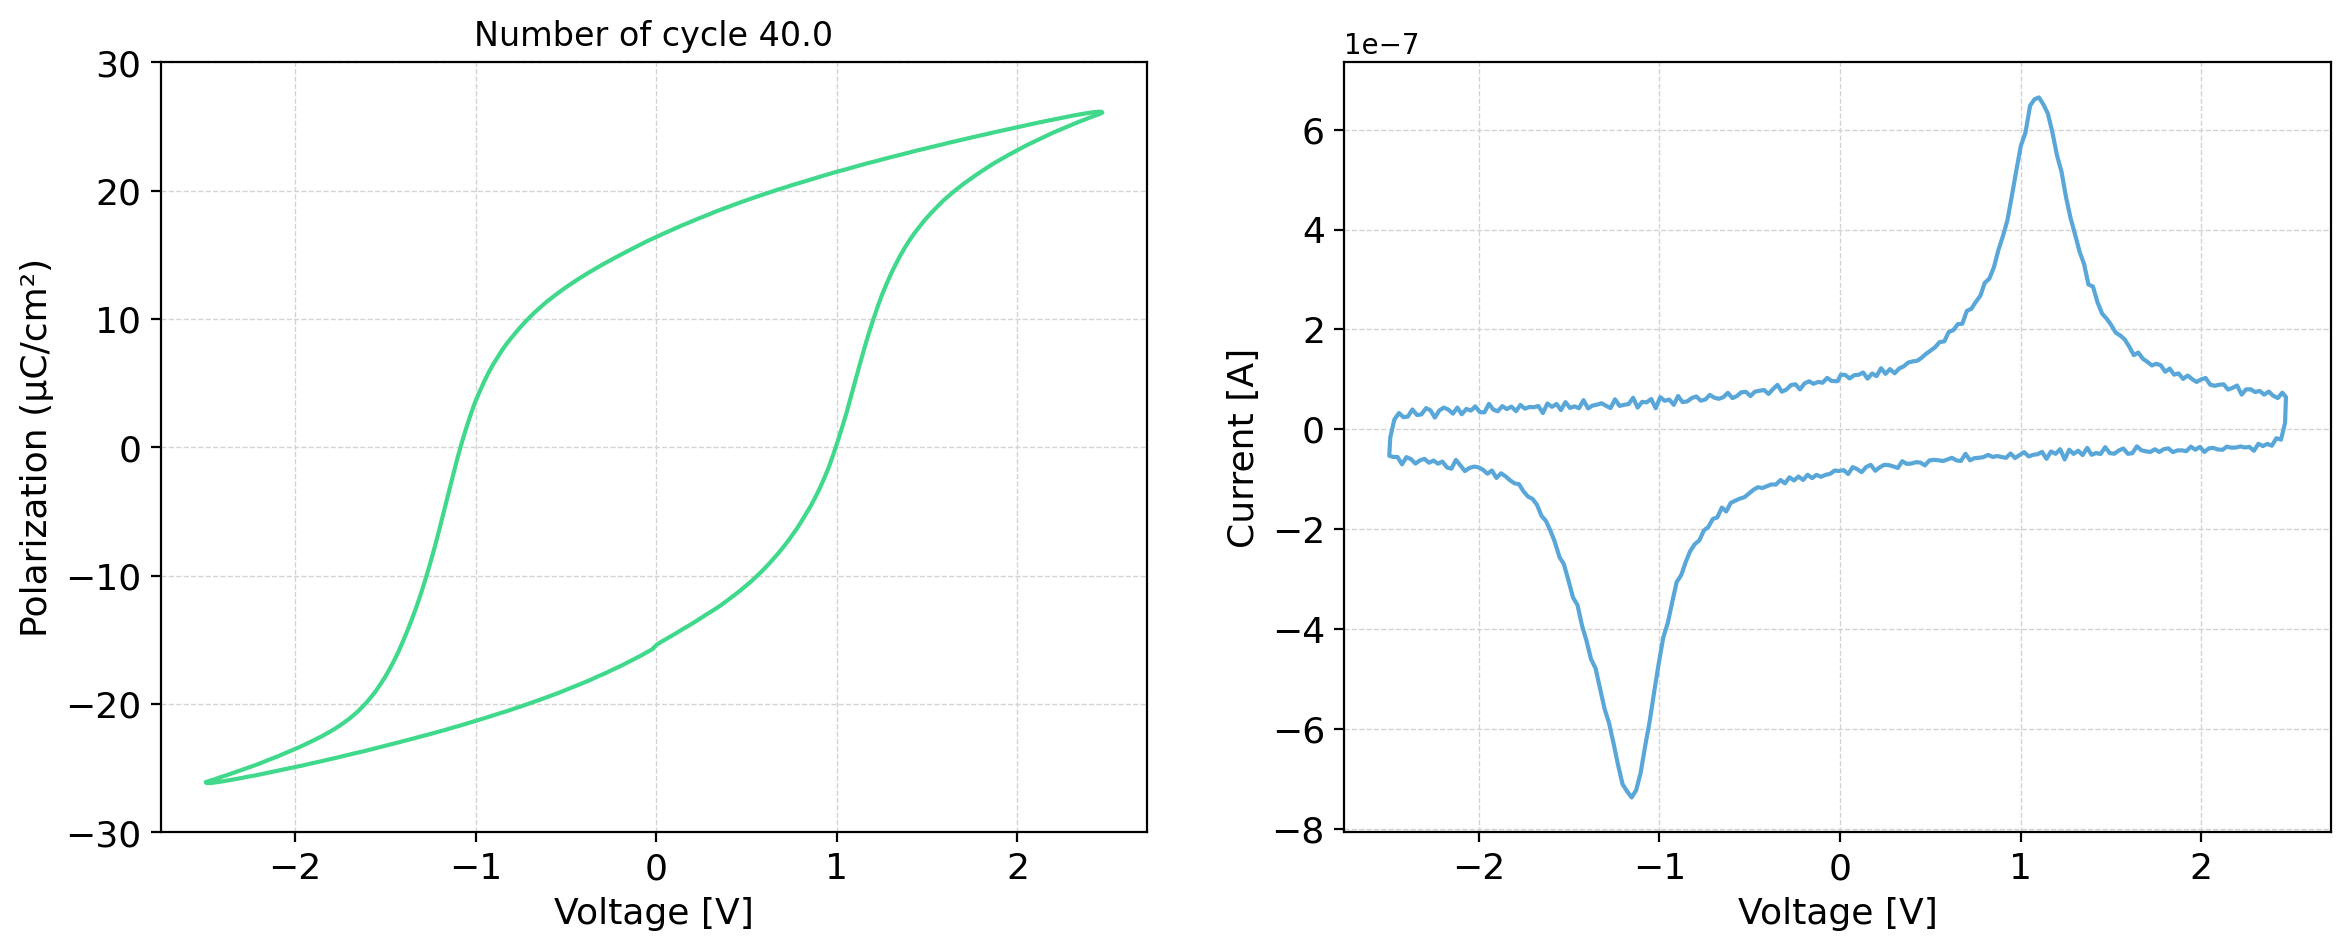

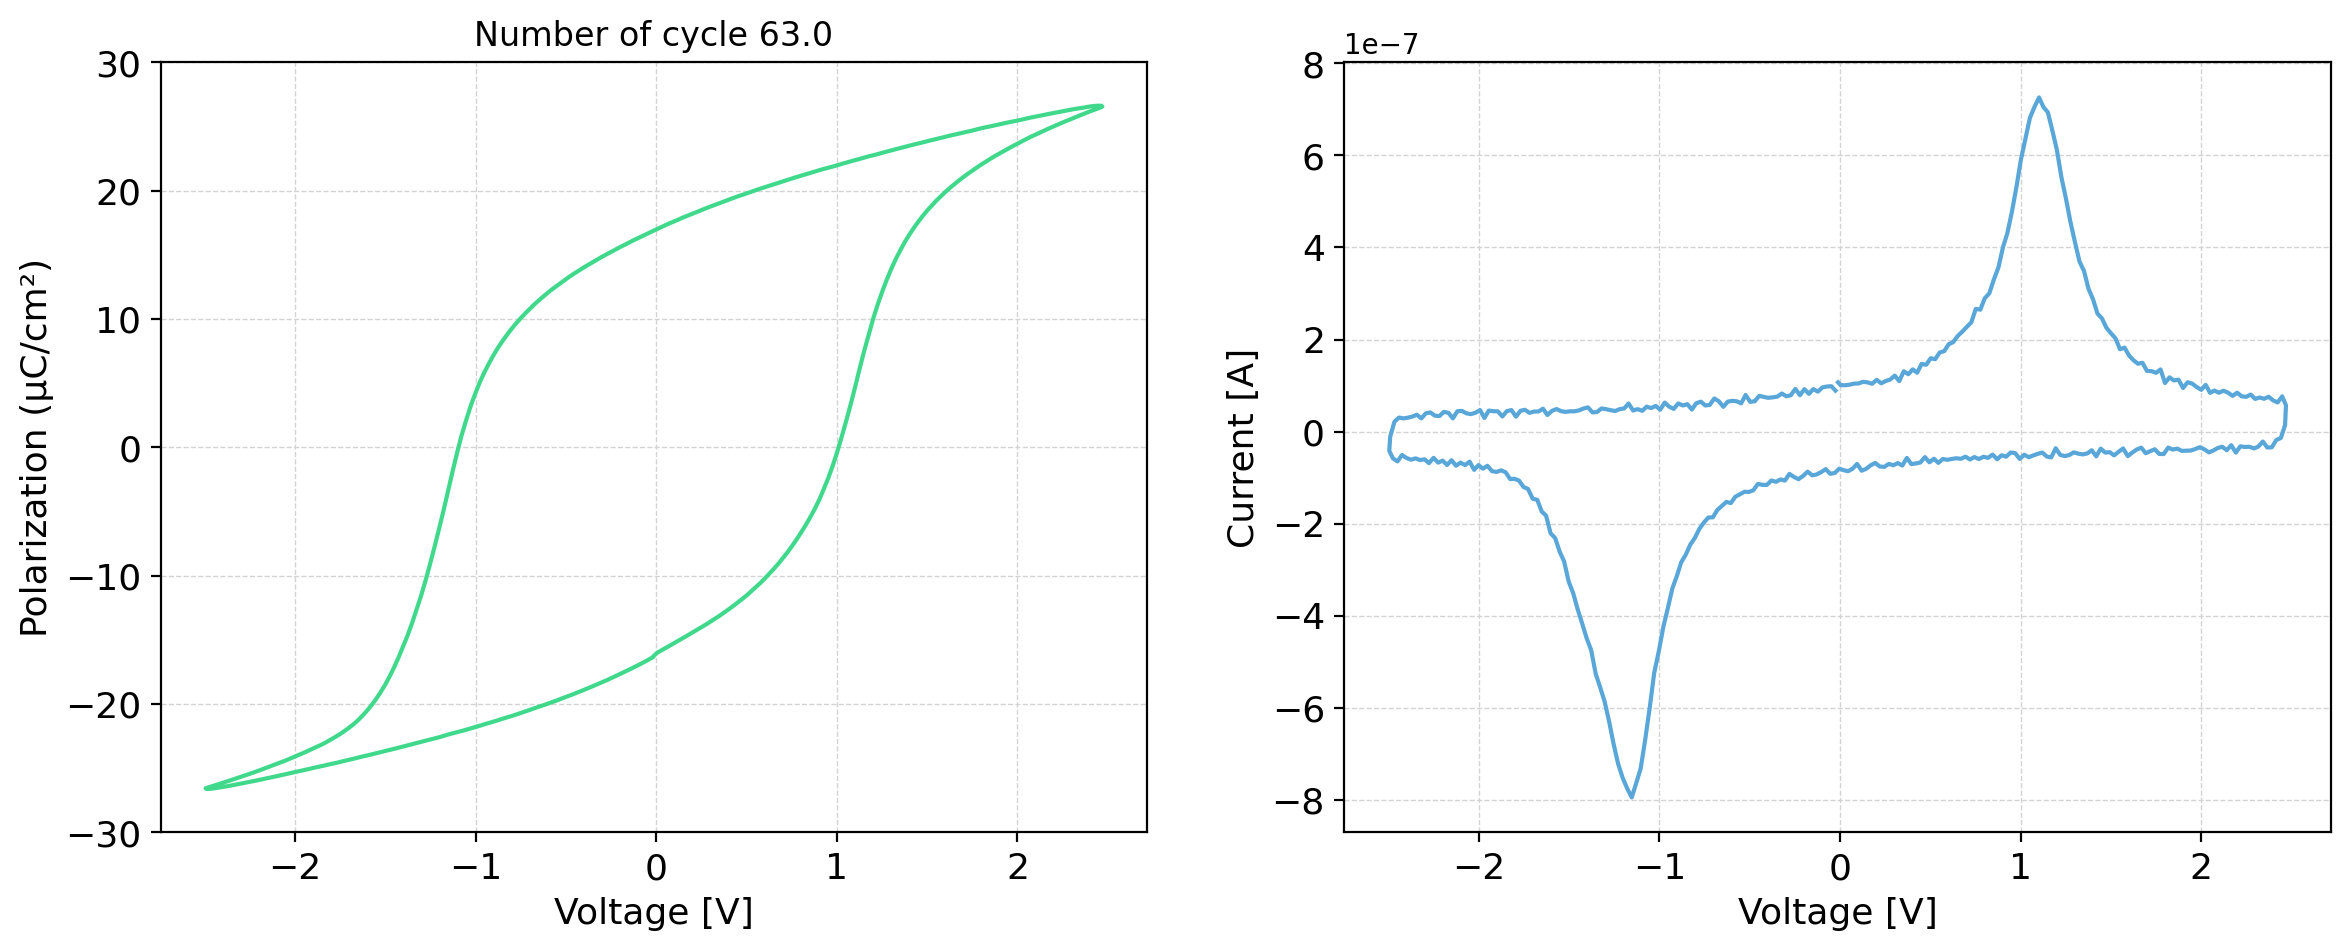

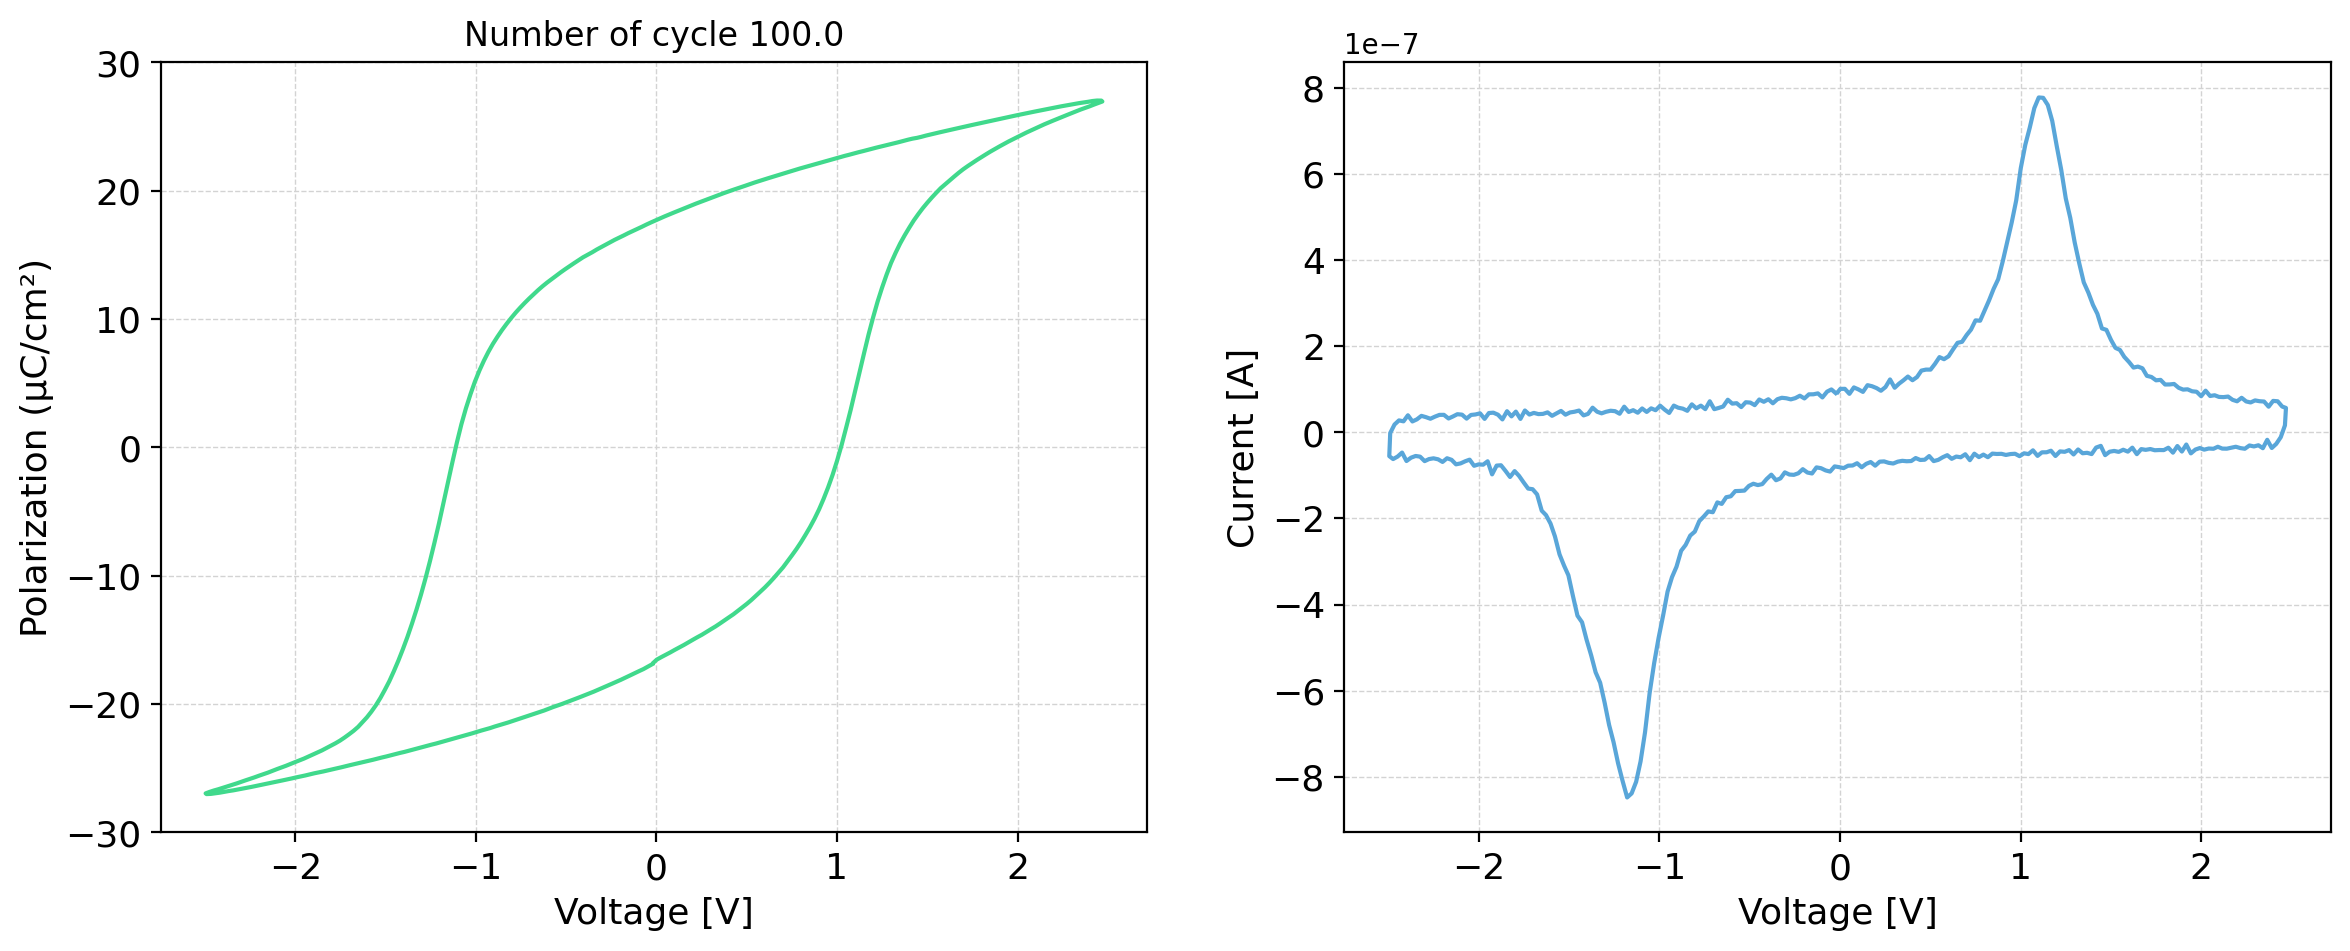

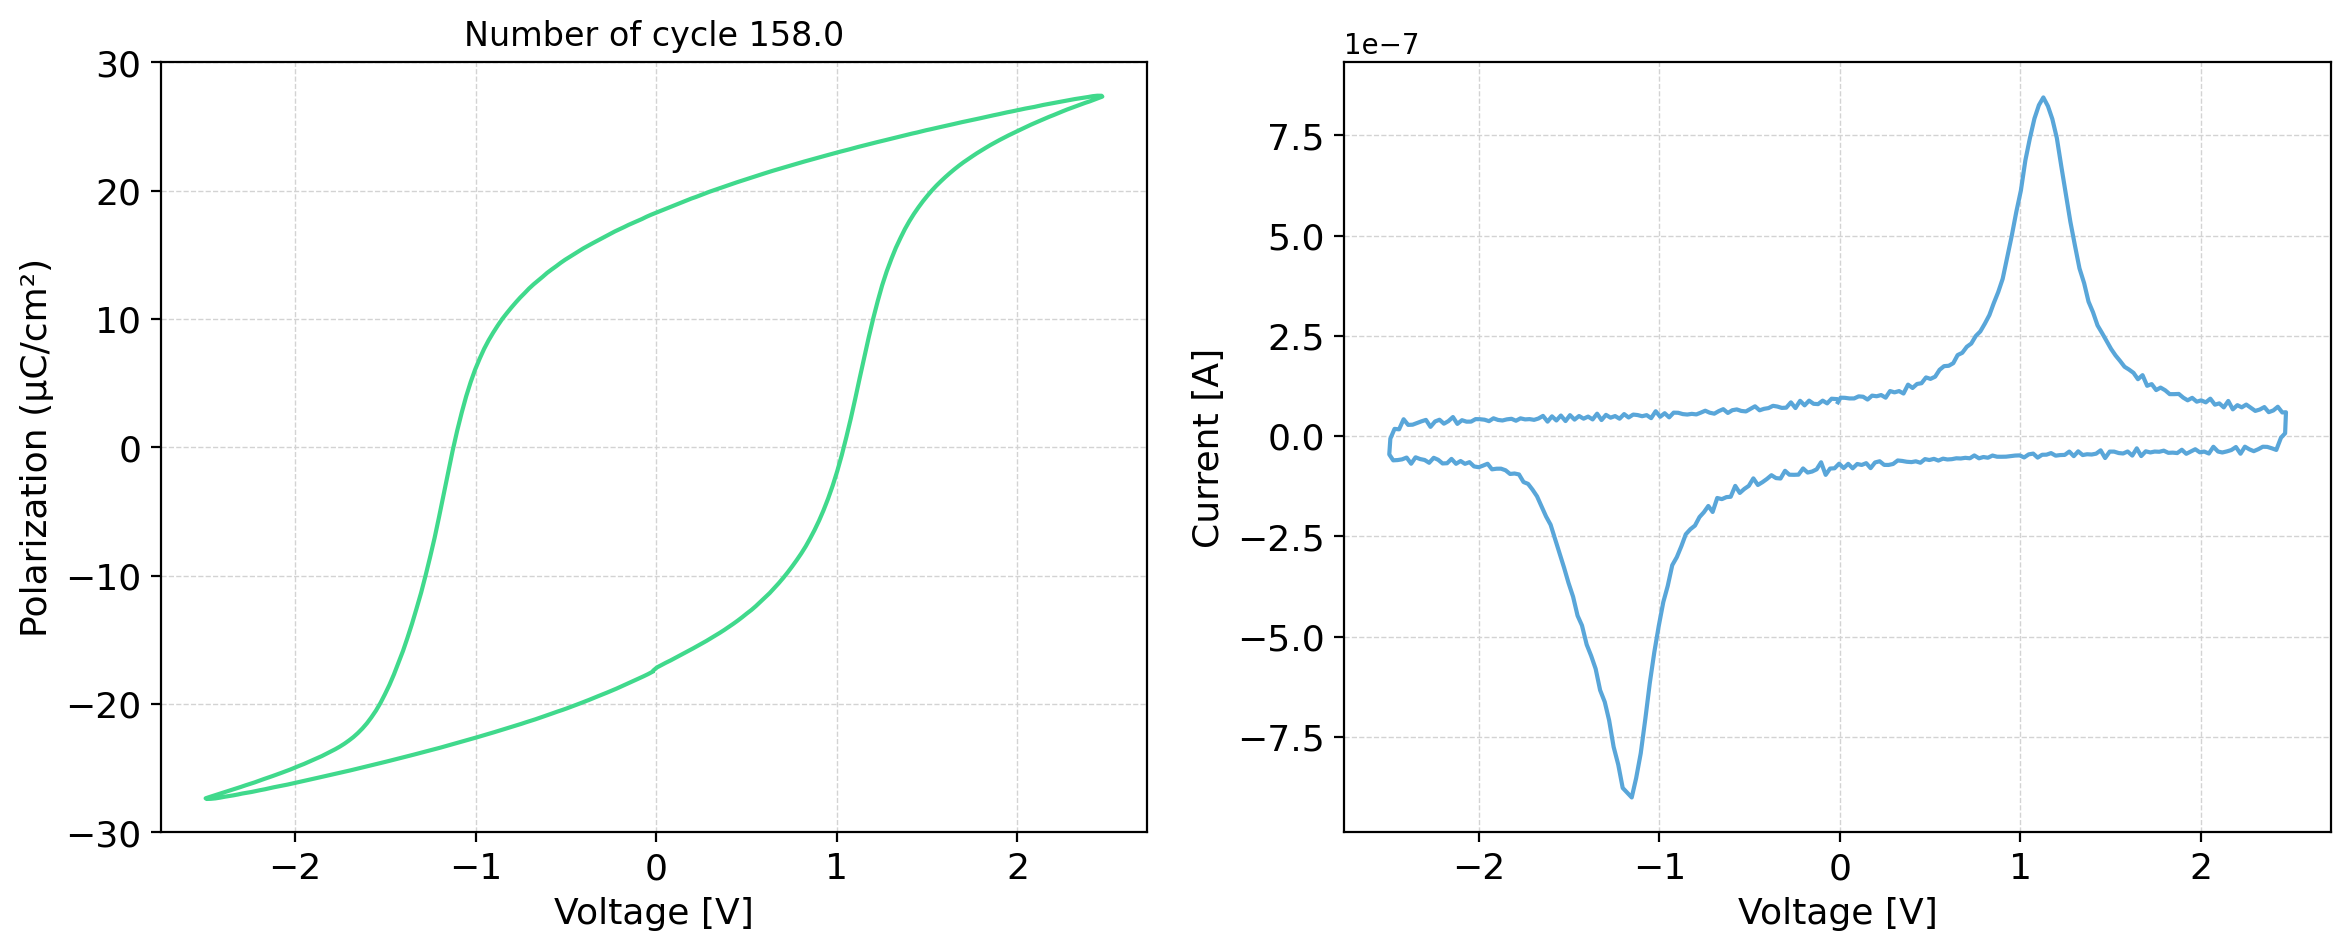

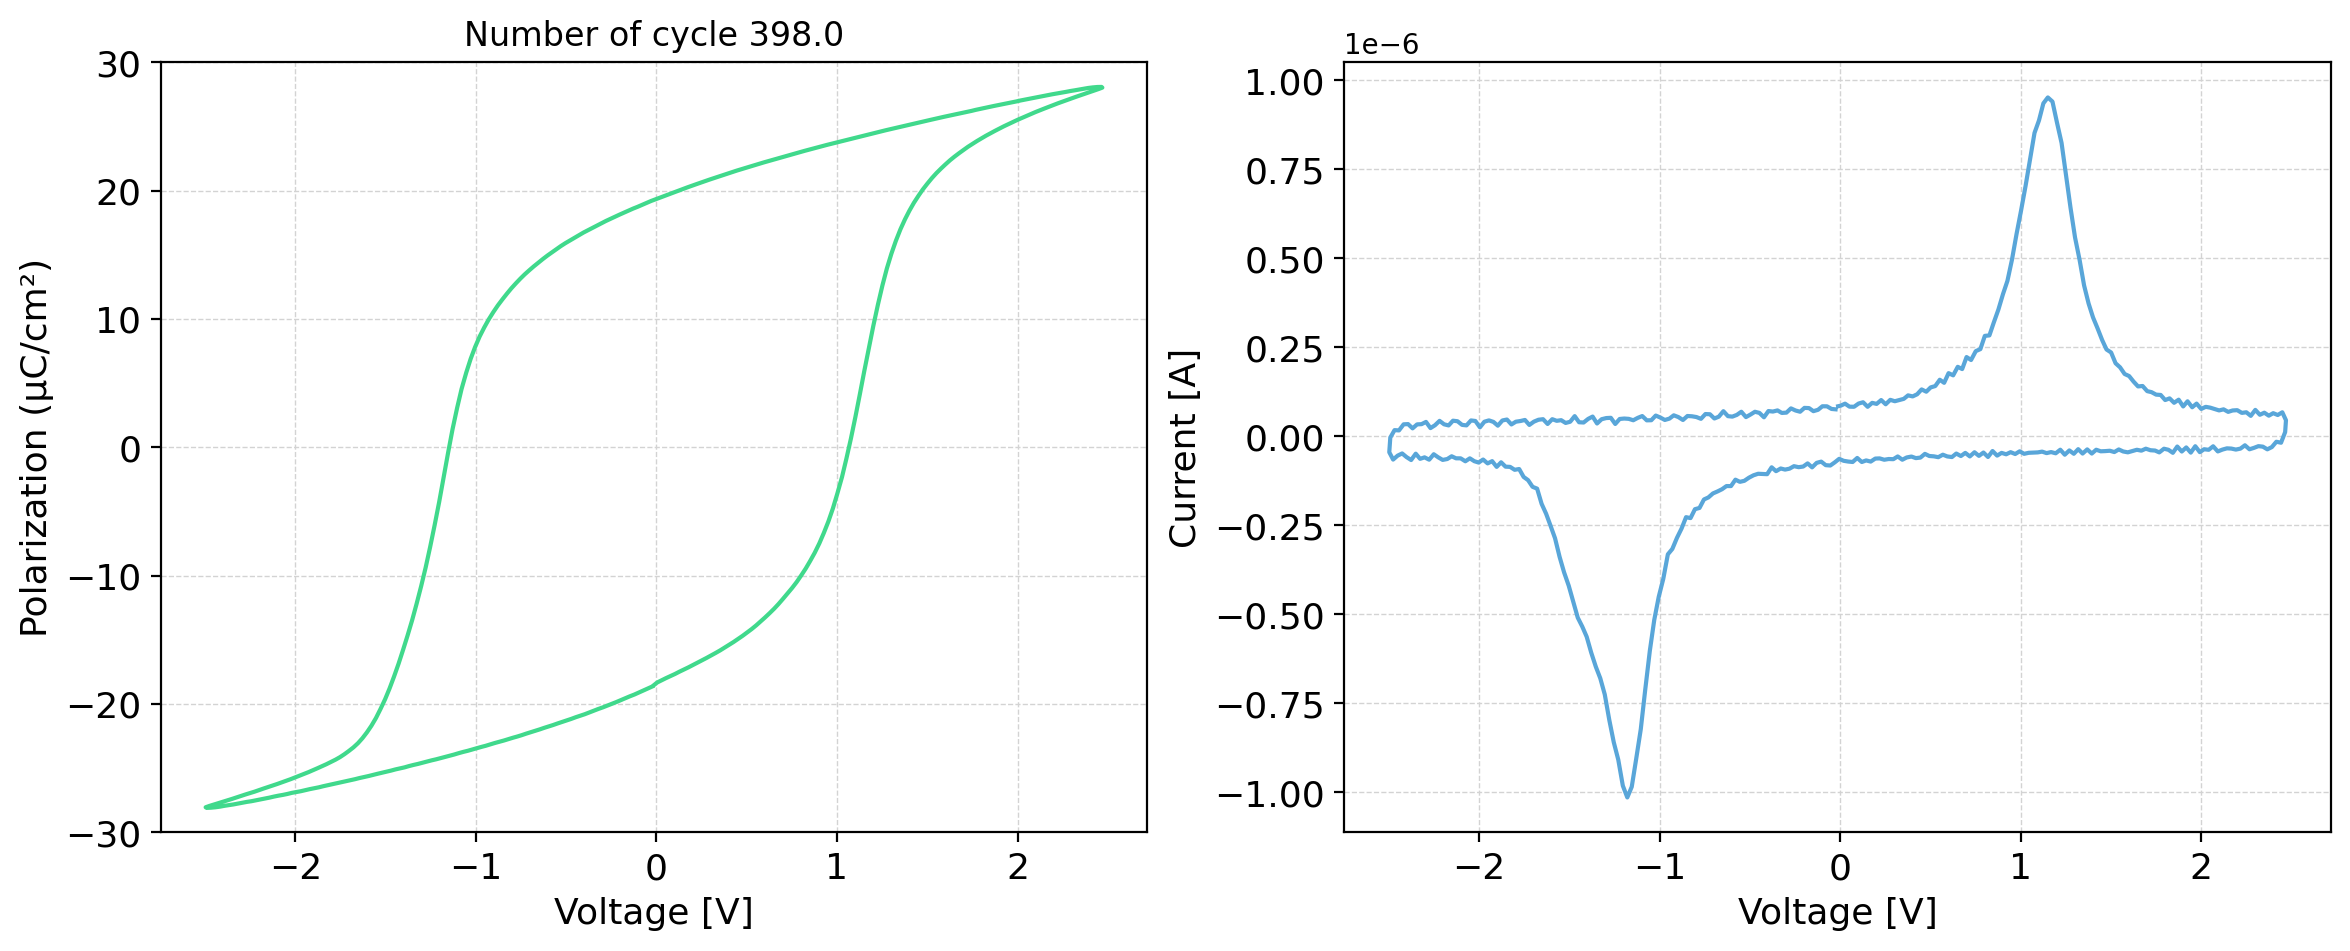

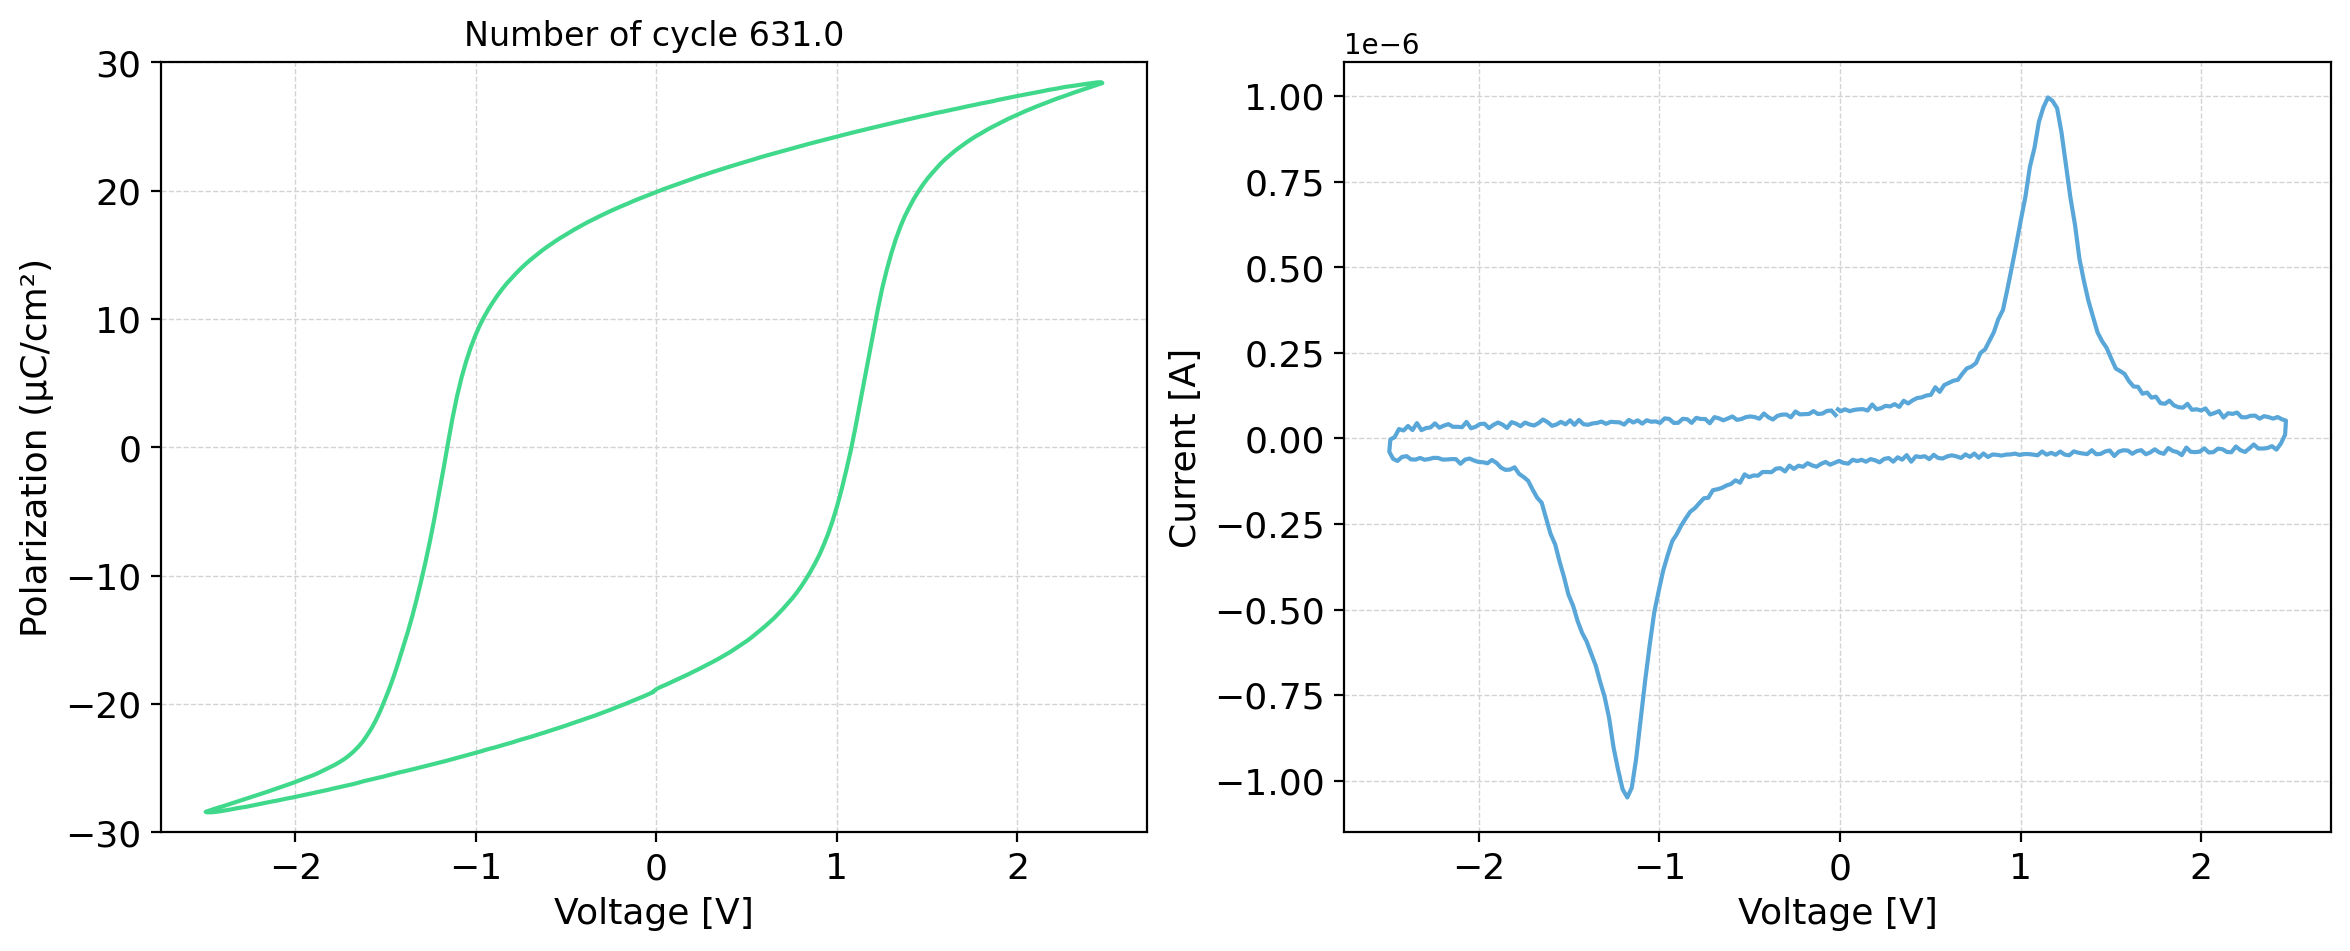

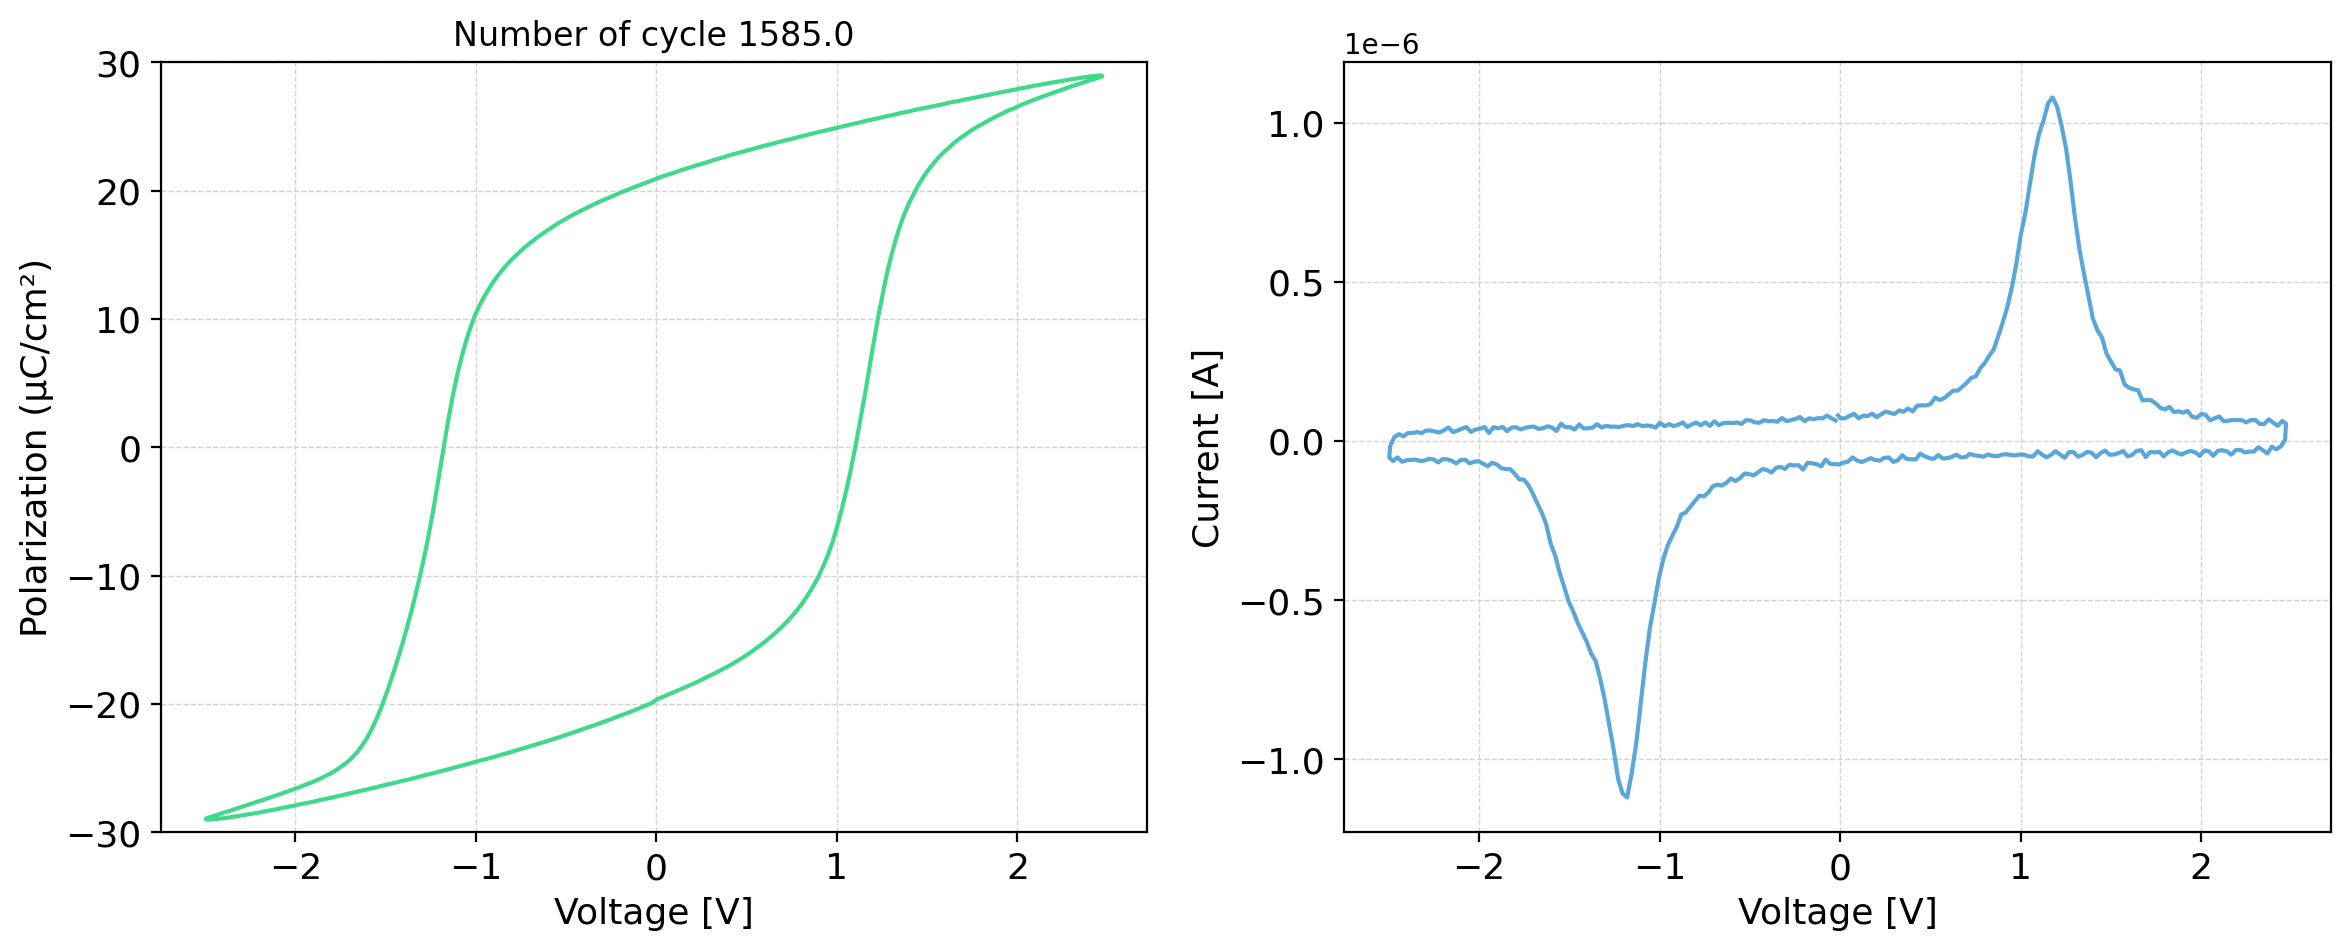

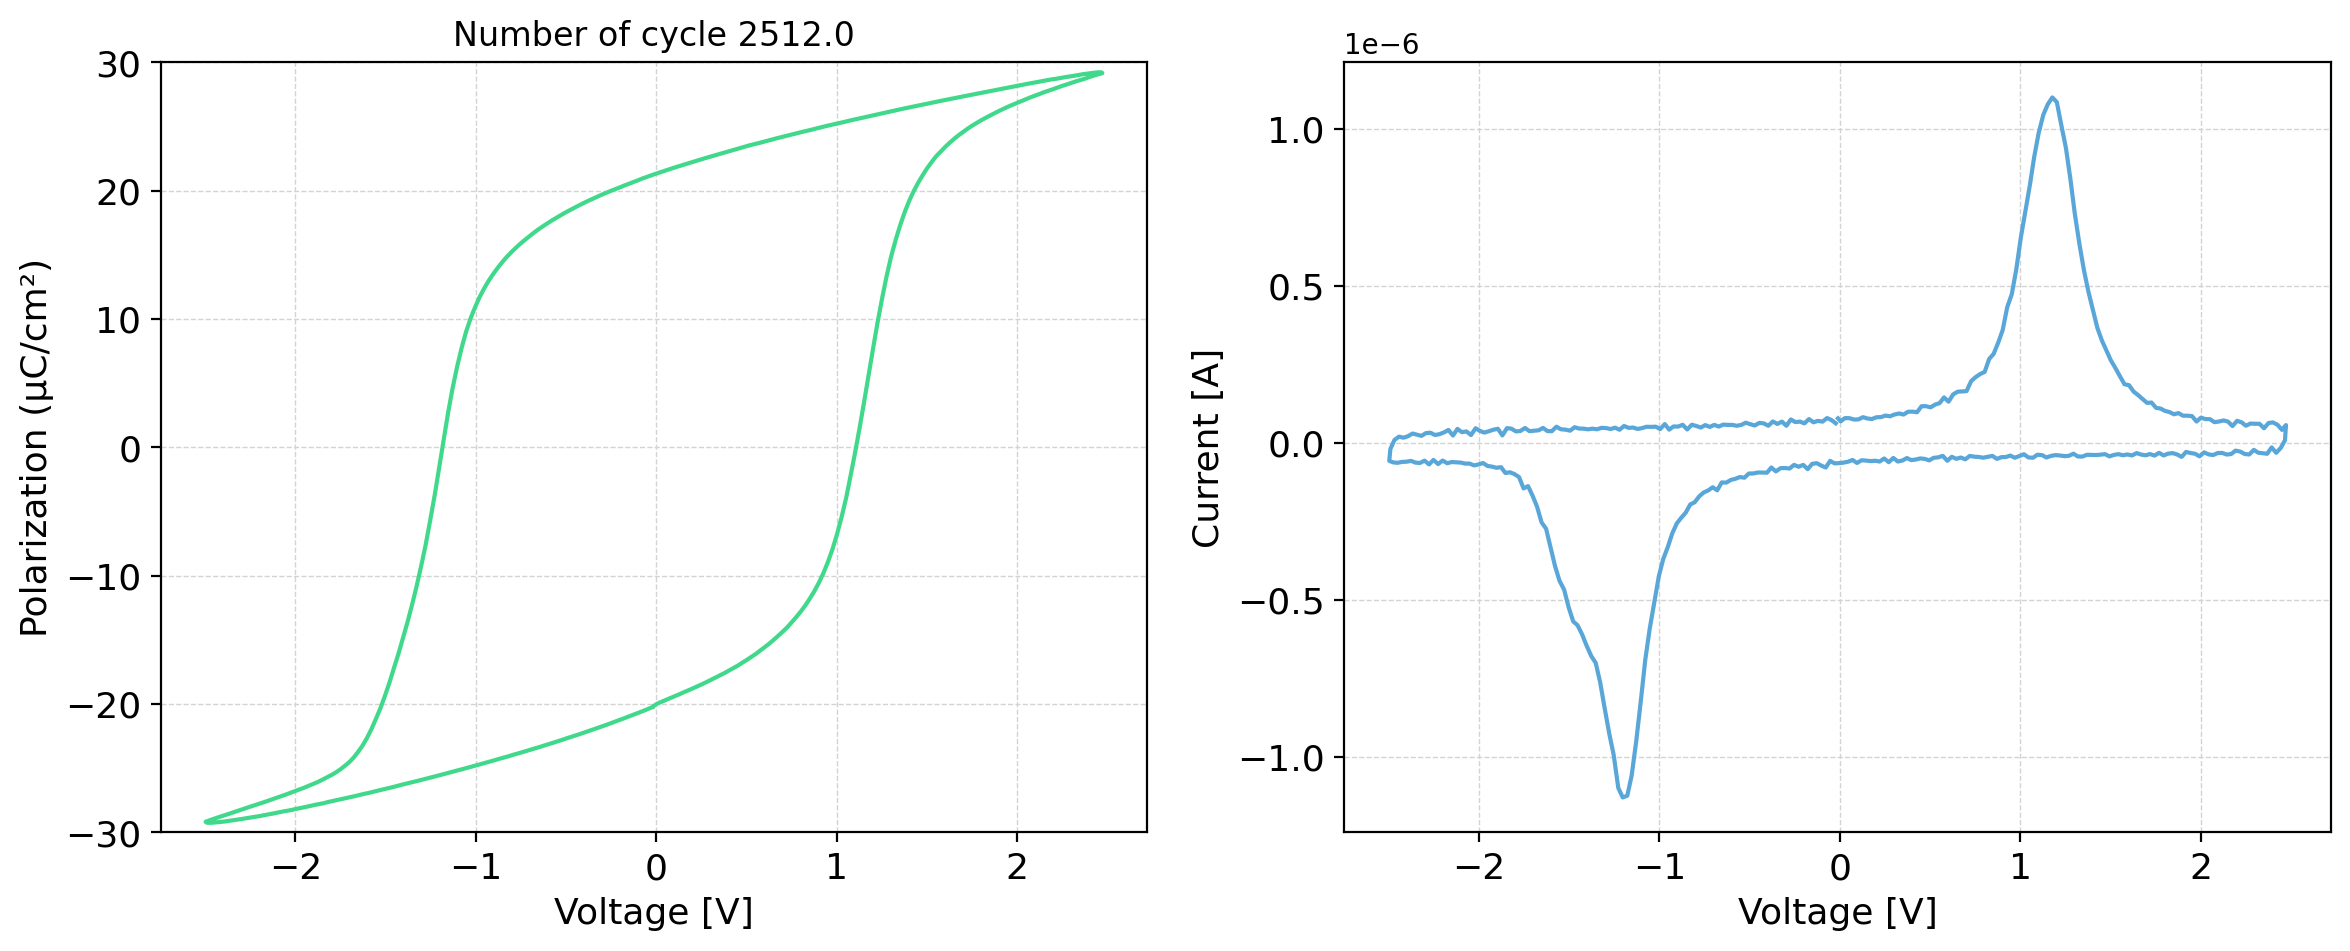

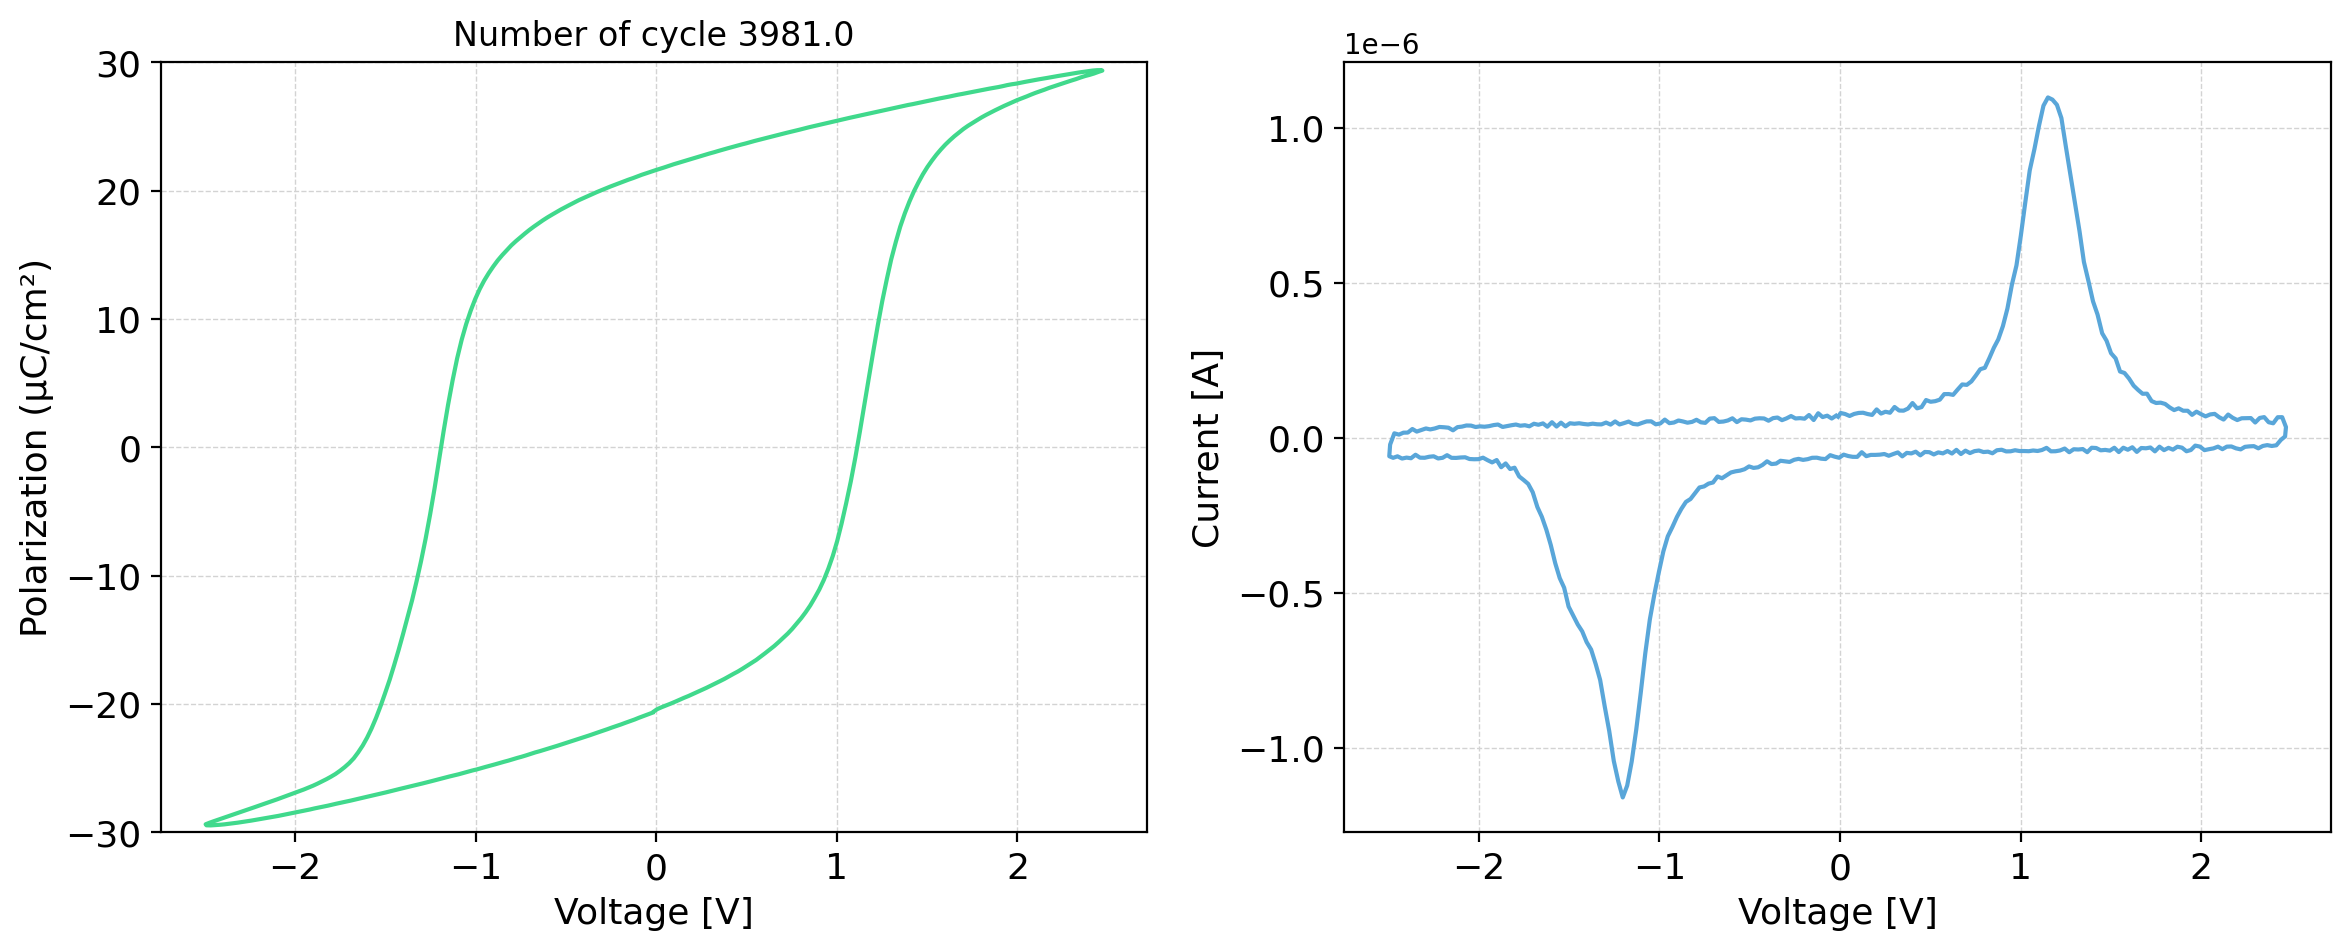

In [6]:
# Trouver le max global
ymax = max(df['P1 [uC/cm2]'].abs().max() for df in DHM_dataframe)
ymax = int(np.ceil(ymax / 5.0)) * 5

output_plot = os.path.join(output_path_02, "DHM plot")
output_video = os.path.join(output_path_02, "Video")
os.makedirs(output_plot, exist_ok=True)  # Ensure output directory exists
os.makedirs(output_video, exist_ok=True)  # Ensure output directory exists

for i,j in zip(range(len(DHM_dataframe)), Cycles_total):
    
    df = DHM_dataframe[i]

    # Create the figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(df['V+ [V]'], df['P1 [uC/cm2]'], color=(0.25, 0.85, 0.55))
    axs[0].set_xlabel("Voltage [V]", fontsize = label_size)
    axs[0].set_ylabel("Polarization (μC/cm²)", fontsize = label_size)
    axs[0].set_ylim(-ymax, ymax)
    axs[0].set_title(f'Number of cycle {j}')
    axs[0].tick_params(axis='both', labelsize= label_size)
    axs[0].grid(True, color='lightgray', linestyle='--', linewidth=0.5)

    axs[1].plot(df['V+ [V]'], df['I1 [A]'], color=(0.35, 0.65, 0.85))
    axs[1].set_xlabel("Voltage [V]", fontsize = label_size)
    axs[1].set_ylabel("Current [A]", fontsize = label_size)
    axs[1].tick_params(axis='both', labelsize= label_size)
    axs[1].grid(True, color='lightgray', linestyle='--', linewidth=0.5)


    plt.savefig(os.path.join(output_plot, f"{base_name}_DHM_{i}_cycle_{j}.png"), dpi=300)

    plt.show()
    plt.close()

